In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import scipy
import math
import copy
import noise
import time

In [68]:
# helper functions
def find_neighbours(arr):

    neighbors = []

    for i in range(len(arr)):
        for j, value in enumerate(arr[i]):

            if i == 0 or i == len(arr) - 1 or j == 0 or j == len(arr[i]) - 1:
                # corners
                new_neighbors = []
                if i != 0:
                    new_neighbors.append(arr[i - 1][j])  # top neighbor
                if j != len(arr[i]) - 1:
                    new_neighbors.append(arr[i][j + 1])  # right neighbor
                if i != len(arr) - 1:
                    new_neighbors.append(arr[i + 1][j])  # bottom neighbor
                if j != 0:
                    new_neighbors.append(arr[i][j - 1])  # left neighbor

            else:
                # add neighbors
                new_neighbors = [
                    arr[i - 1][j],  # top neighbor
                    arr[i][j + 1],  # right neighbor
                    arr[i + 1][j],  # bottom neighbor
                    arr[i][j - 1]   # left neighbor
                ]

            neighbors.append({
                value: new_neighbors
                })

    return neighbors


def neighbors_full(matrix,radius, row_number, column_number):
     return [[matrix[i][j] if  i >= 0 and i < len(matrix) and j >= 0 and j < len(matrix[0]) else 0
                for j in range(column_number-1-radius, column_number+radius)]
                    for i in range(row_number-1-radius, row_number+radius)]


def flatten(l):
    return [item for sublist in l for item in sublist]

def sigmoid(x):
            return 1.0 / (1.0 + np.exp(-0.5*x))

def calculate_next_step(pheromones_l,pheromones_r):
    p_left = ((5+pheromones_l)**2)/((5+pheromones_l)**2+((5+pheromones_r)**2))
    p_right = 1 - p_left

    return p_left, p_right

def take_next_step(pheromones_l,pheromones_r):
    return 0.5 + 0.5*np.tanh((pheromones_l+pheromones_r)/100 -1)


def multiplot(nodes,one=False,two=False,total=False,exp=0):
    food_dist = []
    pheromone_dist = []
    max_capa_dist = []
    capacity_dist = []


    for i in range(len(nodes)):
        food_dist.append(nodes[i].get_food())
        capacity_dist.append(nodes[i].get_capacity())
        max_capa_dist.append(nodes[i].get_max_capacity())
        pheromone_dist.append(nodes[i].get_pheromones())


    food_dist = np.array(food_dist).reshape(-1,int(np.sqrt(len(nodes))))
    food_dist = np.flip(food_dist.T,0)

    capacity_dist = np.array(capacity_dist).reshape(-1,int(np.sqrt(len(nodes))))
    capacity_dist = np.flip(capacity_dist.T,0)

    max_capa_dist = np.array(max_capa_dist).reshape(-1,int(np.sqrt(len(nodes))))
    max_capa_dist = np.flip(max_capa_dist.T,0)
    
    pheromone_dist = np.array(pheromone_dist).reshape(-1,int(np.sqrt(len(nodes))))
    pheromone_dist = np.flip(pheromone_dist.T,0)


    if one == True:
        fig = plt.figure(figsize=(10,8),dpi=10)
        sns.heatmap(capacity_dist,cmap="viridis",annot=False,vmax=1,xticklabels=False,yticklabels=False).set(title='Capacity',xlabel='X-Axis',ylabel='Y-Axis')

        name = 'plot_' + str(int(time.time()))
        plt.savefig(f'./output/{name}')

    
    if two == True:
        fig, axes = plt.subplots(1, 2,figsize=(20,8),dpi=10)
        sns.heatmap(capacity_dist,ax=axes[0],cmap="viridis",annot=False,vmax=5,xticklabels=False,yticklabels=False)
        axes[0].set_title('Capacity')
        axes[0].set_xlabel('X-Axis', fontsize=10)
        axes[0].set_ylabel('Y-Axis', fontsize=10)
        sns.heatmap(pheromone_dist,ax=axes[1],cmap="viridis",annot=False,vmax=100,xticklabels=False,yticklabels=False)
        axes[1].set_title('Pheromones')
        axes[1].set_xlabel('X-Axis', fontsize=10)
        axes[1].set_ylabel('Y-Axis', fontsize=10)
        plt.tight_layout()

    

        name = exp + 'plot_' + str(int(time.time()))
        plt.savefig(f'./output/{name}',dpi=500)
        plt.show()

    if total == True:
        fig, axes = plt.subplots(1, 3,figsize=(20,8),dpi=200)
        sns.heatmap(capacity_dist,ax=axes[0],cmap="viridis",annot=False,vmax=1,xticklabels=False,yticklabels=False)
        axes[0].set_title('Location')
        axes[0].set_xlabel('X-Axis', fontsize=10)
        axes[0].set_ylabel('Y-Axis', fontsize=10)
        sns.heatmap(pheromone_dist,ax=axes[1],cmap="viridis",annot=False,vmax=200,xticklabels=False,yticklabels=False)
        axes[1].set_title('Pheromones')
        axes[1].set_xlabel('X-Axis', fontsize=10)
        axes[1].set_ylabel('Y-Axis', fontsize=10)
        # sns.heatmap(max_capa_dist,ax=axes[2],cmap="terrain",annot=False,vmax=20,xticklabels=False,yticklabels=False)
        # axes[2].set_title('maximum capacity')
        # axes[2].set_xlabel('X-Axis', fontsize=10)
        # axes[2].set_ylabel('Y-Axis', fontsize=10)
        sns.heatmap(food_dist,ax=axes[2],cmap="viridis",annot=False,vmax=40,xticklabels=False,yticklabels=False)
        axes[2].set_title('Food')
        axes[2].set_xlabel('X-Axis', fontsize=10)
        axes[2].set_ylabel('Y-Axis', fontsize=10)

        plt.tight_layout()
        name = exp + '_plot_' + str(int(time.time()))
        plt.savefig(f'./output/{name}',dpi=500)
        plt.show()
        plt.close(fig) 



In [5]:
# nodes class and ant class
class CreateNodes:
    def __init__(self, food=0, pheromones=0,x_coord=0, y_coord=0,evaporation_rate=1):
        self._food = food
        self._pheromones = pheromones
        self._max_pheromones = 100
        self._evaporation_rate = evaporation_rate
        self._capacity = 0
        self._max_capacity = 20
        self._x_coordinates = x_coord
        self._y_coordinates = y_coord
        self._connected_nodes = None
        self._connected_nodes_backwards = None
        self._connected_nodes_forwards = None
        self._node_number = None

    def create_label(self,label):
        self._node_number = label

    def update_food(self, food):
        self._food = food 
        
    def increase_food(self):
        self._food += 1

    def decrease_food(self):
        self._food -= 1

    def update_pheromones(self, dropped_pheromones):
        self._pheromones = self._pheromones + dropped_pheromones

    def reset_pheromones(self):
        self._pheromones = 0

    def set_pheromones(self,pheromones):
        self._pheromones = pheromones

    def evaporation(self):
        self._pheromones = self._pheromones - self._pheromones * self._evaporation_rate

    def set_capacity(self):
        self._capacity = 10

    def update_capacity(self, new_capacity):
        self._capacity = self._capacity + new_capacity

    def increase_capacity(self):
        self._capacity = self._capacity + 1

    def reduce_capacity(self):
        self._capacity = self._capacity - 1

    def update_max_capacity(self, max_capacity):
        self._max_capacity = max_capacity

    def update_x_coordinates(self, x_coord):
        self._x_coordinates = x_coord

    def update_y_coordinates(self, y_coord):
        self._y_coordinates = y_coord

    def update_connected_nodes(self, connected_nodes):
        self._connected_nodes = connected_nodes

    def update_connected_nodes_backwards(self):
        self._connected_nodes_backwards = [node for node in self._connected_nodes if node < self._node_number]

    def update_connected_nodes_forwards(self):
        self._connected_nodes_forwards = [node for node in self._connected_nodes if node > self._node_number]

    def get_label(self):
        return self._node_number

    def get_food(self):
        return self._food

    def get_pheromones(self):
        return self._pheromones

    def get_capacity(self):
        return self._capacity

    def get_x_coordinates(self):
        return self._x_coordinates

    def get_y_coordinates(self):
        return self._y_coordinates

    def get_node_number(self):
        return self._node_number

    def get_connected_nodes(self):
        return self._connected_nodes

    def get_connected_nodes_backwards(self):
        return self._connected_nodes_backwards
    
    def get_connected_nodes_forwards(self):
        return self._connected_nodes_forwards

    def get_max_capacity(self):
        return self._max_capacity

class Ants:
    def __init__(self):
        self._food = 0
        self._location = None
        self._ant_number = None

    def food_level(self):
        return self._food

    def pick_up_food(self, food):
        self._food = food
    
    def drop_food(self):
        self._food = 0
        
    def update_ant_number(self, ant_number):
        self._ant_number = ant_number

    def get_ant_number(self):
        return self._ant_number

    def update_location(self,location):
        self._location = location
    
    def get_location(self):
        return self._location

In [107]:
# create nodes for the experiment
def create_nodes(n,evaporation_rate,experiment=1,randomise_capacity=False,terrain=False,nests = False,realistic_world=True):
    nodes = {}

    # experiment 1
    if experiment == 1:
        population = [0,0] # w/ 0,0 there is no food
        weights = [0.5,0.5]

    elif experiment == 2:
        # experiment 2
        population = [0,1] # w/ 0,0 there is no food
        weights = [0.5,0.5]

    elif experiment == 3:
            # experiment 3
        population = [0,40] # w/ 0,0 there is no food
        weights = [99/100,1/100]

    elif experiment == 4:
        population = [0,1,2] # w/ 0,0 there is no food
        weights = [0.5,0.3,0.2]

    ys = []

    for i in range(0,int(math.sqrt(n))):
        for j in range(0,int(math.sqrt(n))):
            ys.append(j)

    ys = sorted(ys)

    
    nodes = {}
    node_labels = list(range(n))

    for i in range(n):
        food = random.choices(population, weights=weights)[0]
        nodes[i] = CreateNodes(food=food,x_coord=i,evaporation_rate=evaporation_rate)
        nodes[i].create_label(i)

    for idx, j in enumerate(ys):
        nodes[node_labels[idx]].update_y_coordinates(j)

    node_array = np.array(node_labels).reshape(-1,int(math.sqrt(n)))
    neigbors_dict = find_neighbours(node_array)

    for i in range(n):
        nodes[i].update_connected_nodes(neigbors_dict[i][i])
        nodes[i].update_connected_nodes_backwards()
        nodes[i].update_connected_nodes_forwards()


    if randomise_capacity:
        for i in range(n):
            nodes[i].update_max_capacity(random.randint(5,20))

    if realistic_world:
        shape = (int(np.sqrt(n)),int(np.sqrt(n)))
        scale = 70.0
        octaves = 60
        persistence = 0.2
        lacunarity = 2
        base = random.randint(20,40)
        print(base)

        world = np.zeros(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                world[i][j] = noise.pnoise2(i/scale, 
                                            j/scale, 
                                            octaves=octaves, 
                                            persistence=persistence, 
                                            lacunarity=lacunarity, 
                                            repeatx=1024, 
                                            repeaty=1024, 
                                            base=127) # 42 good, 12 linear, # 33 good # try 181 

        world = np.around(np.interp(world, (world.min(), world.max()), (0,20)),0)
        
        # for i in range(len(world)):
        #     for j in range(len(world)):
        #         if world[i][j] > 20:
        #             world[i][j] = world[i][j] - world[i][j] * sigmoid(world[i][j]- 10)
        #         else:
        #             world[i][j] = world[i][j]

        
        counter = 0
        for i in range(shape[0]):
            for j in range(shape[0]):
                nodes[counter].update_max_capacity(world[i,j])
                counter += 1

    if terrain:
        A = np.arange(n).reshape(-1,int(np.sqrt(n)))
        all_nodes = A.flatten().tolist()

    
        for i in range(20):
            tree = random.choice(all_nodes)
            tree_index = np.where(A==tree)
            tree_values = flatten(neighbors_full(A,random.randint(5,7),int(tree_index[0]),int(tree_index[1])))

            for node in range(len(nodes)):
                if nodes[node].get_node_number() in tree_values:
                    nodes[node].set_pheromones(-np.inf)
                    nodes[node].update_max_capacity(0)
                    nodes[node].update_capacity(0)

    if nests:
        A = np.arange(n).reshape(-1,int(np.sqrt(n)))
        all_nodes = A.flatten().tolist()

    
        for i in range(15):
            nest = random.choice(all_nodes)
            nest_index = np.where(A==nest)
            nest_values = flatten(neighbors_full(A,random.randint(3,7),int(nest_index[0]),int(nest_index[1])))

            for node in range(len(nodes)):
                if nodes[node].get_node_number() in nest_values:
                    nodes[node].update_food(40)


    return nodes, node_array

In [91]:
def model(nodes,steps,ants_per_step,max_ants):
    ants = []
    no_ants = len(ants)

    A = np.arange(len(nodes)).reshape(int(np.sqrt(len(nodes))),-1)
    start_node =  A[35,5] # this has to be automated
    nest_nodes = A[35:65,0:20].flatten().tolist()
    no_food_zone = A[35:65,0:20].flatten().tolist()

    for i in no_food_zone:
        nodes[i].update_food(0)
        nodes[i].update_max_capacity(40)

    nodes[start_node].update_max_capacity(10000)
    counter = 0

    for step in range(steps):
        for node in nodes: # evaporates some of the pheromones each step
            nodes[node].evaporation()
            pass
            

        if len(ants) < max_ants: # adding new ants until limit is reached at every step
            for i in range(ants_per_step): 
                test_ant = Ants()
                test_ant.update_ant_number(counter)
                test_ant.update_location(start_node)
                ants.append(test_ant)
                nodes[start_node].increase_capacity()
                counter += 1


        for i in range(len(ants)):
            location = ants[i].get_location()
        
            # has no food
            if ants[i].food_level() == 0:
                next_nodes = nodes[location].get_connected_nodes_forwards()

                pheromones_l = nodes[next_nodes[0]].get_pheromones()
                try:
                    pheromones_r = nodes[next_nodes[1]].get_pheromones()
                except:
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    nodes[current_location].update_capacity(0)
                    ants[i].update_location(start_node)

                    continue
                
                probability_l, probability_r = calculate_next_step(pheromones_l,pheromones_r)

                # if step < 10:
                #     next_step_prob = 1
                # else:
                
                next_step_prob = take_next_step(pheromones_l,pheromones_r)



                if random.random() < next_step_prob:
                    if random.random() <= probability_l:
                        if nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if nodes[next_nodes[0]].get_pheromones() >= 1000:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(2) # update next nodes pheromoes

                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity
                            if nodes[next_nodes[0]].get_food() != 0:
                                ants[i].pick_up_food(1) # pick up food 
                                nodes[next_nodes[0]].decrease_food() # remove food from next node



                        elif nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1]) # update ants location
                            
                            if nodes[next_nodes[1]].get_pheromones() >= 1000: # update pheromones
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(2)

                            nodes[next_nodes[1]].update_capacity(1)

                            if nodes[next_nodes[1]].get_food()!= 0:
                                ants[i].pick_up_food(1)
                                nodes[next_nodes[1]].decrease_food()


                        else:
                            nodes[location].update_pheromones(1)
                            continue


                    elif random.random() > probability_l:
                        if nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():

                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1])

                            if nodes[next_nodes[1]].get_pheromones() >= 1000:
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(2)

                            nodes[next_nodes[1]].update_capacity(1)
                        
                            if nodes[next_nodes[1]].get_food()!= 0:
                                ants[i].pick_up_food(1)
                                nodes[next_nodes[1]].decrease_food()





                        elif nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if nodes[next_nodes[0]].get_pheromones() >= 1000:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(2) # update next nodes pheromoes

                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity
                            if nodes[next_nodes[0]].get_food() != 0:
                                ants[i].pick_up_food(1) # pick up food 
                                nodes[next_nodes[0]].decrease_food()

                        else:
                            nodes[location].update_pheromones(1)
                            continue


                    else:
                        continue

                else:
                    continue


            # ant has food 
            elif ants[i].food_level() == 1:
                next_nodes = nodes[location].get_connected_nodes_backwards()
                
                pheromones_l = nodes[next_nodes[0]].get_pheromones()
                try:
                    pheromones_r = nodes[next_nodes[1]].get_pheromones()
                except:
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    nodes[current_location].update_capacity(0)
                    ants[i].update_location(start_node)
                    continue

                

                probability_l, probability_r = calculate_next_step(pheromones_l,pheromones_r)

                if probability_l == probability_r:
                    # print(ants[i].get_ant_number(), 'WARNING! STRAY ANT')
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    # nodes[current_location].update_capacity(0)
                    nodes[current_location].reset_pheromones()
                    ants[i].update_location(start_node)

                if ants[i].get_location() < start_node:
                    ants[i].drop_food()
                    current_location = ants[i].get_location()
                    # nodes[current_location].update_capacity(0)
                    # nodes[current_location].reset_pheromones()
                    ants[i].update_location(start_node)



                next_step_prob = take_next_step(pheromones_l,pheromones_r)

                if random.random() < next_step_prob:
                    if random.random() <= probability_l:
                        if nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if next_nodes[0] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()
                                nodes[next_nodes[0]].update_pheromones(10)


                            if nodes[next_nodes[0]].get_pheromones() >= 300:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(10) # update next nodes pheromoes
                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity


                        elif nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1]) # update ants location


                            if next_nodes[1] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()
                                nodes[next_nodes[0]].update_pheromones(10)
                            
                            if nodes[next_nodes[1]].get_pheromones() >= 300: # update pheromones
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(10)

                            nodes[next_nodes[1]].update_capacity(1)

                        else:
                            nodes[location].update_pheromones(1)
                            continue


                    elif random.random() > probability_l:
                        if nodes[next_nodes[1]].get_capacity() < nodes[next_nodes[1]].get_max_capacity():

                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[1])

                            if next_nodes[1] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()
                                nodes[next_nodes[0]].update_pheromones(10)

                            if nodes[next_nodes[1]].get_pheromones() >= 300:
                                pass
                            else:
                                nodes[next_nodes[1]].update_pheromones(10)

                            nodes[next_nodes[1]].update_capacity(1)
                        

                        elif nodes[next_nodes[0]].get_capacity() < nodes[next_nodes[0]].get_max_capacity():
                            
                            nodes[location].reduce_capacity()
                            ants[i].update_location(next_nodes[0]) # update ants location

                            if next_nodes[0] in nest_nodes:
                                ants[i].drop_food()
                                nodes[start_node].increase_food()
                                nodes[next_nodes[0]].update_pheromones(10)

                            if nodes[next_nodes[0]].get_pheromones() >= 300:
                                pass
                            else:
                                nodes[next_nodes[0]].update_pheromones(10) # update next nodes pheromoes

                            nodes[next_nodes[0]].update_capacity(1) # update next nodes capacity


                        else:
                            nodes[location].update_pheromones(1)
                            continue
                        
                    else:
                        continue

                else:
                    continue






            else:
                continue


    nodes[start_node].set_capacity()

    # Analytics
    returning_ants = 0
    exploring_ants = 0

    for i in range(len(ants)):
        if ants[i].food_level() == 1:
            returning_ants += 1
        elif  ants[i].food_level() == 0:
            exploring_ants += 1
       
    print(f'Currently {exploring_ants} ants are searching for food and {returning_ants} ants transport food back to the nest. {nodes[start_node].get_food()} food items are in the nest.')


    # for i in range(len(nodes)):
    #     print(nodes[i].get_pheromones())

                





    return nodes

Currently 2936 ants are searching for food and 1064 ants transport food back to the nest. 499 food items are in the nest.


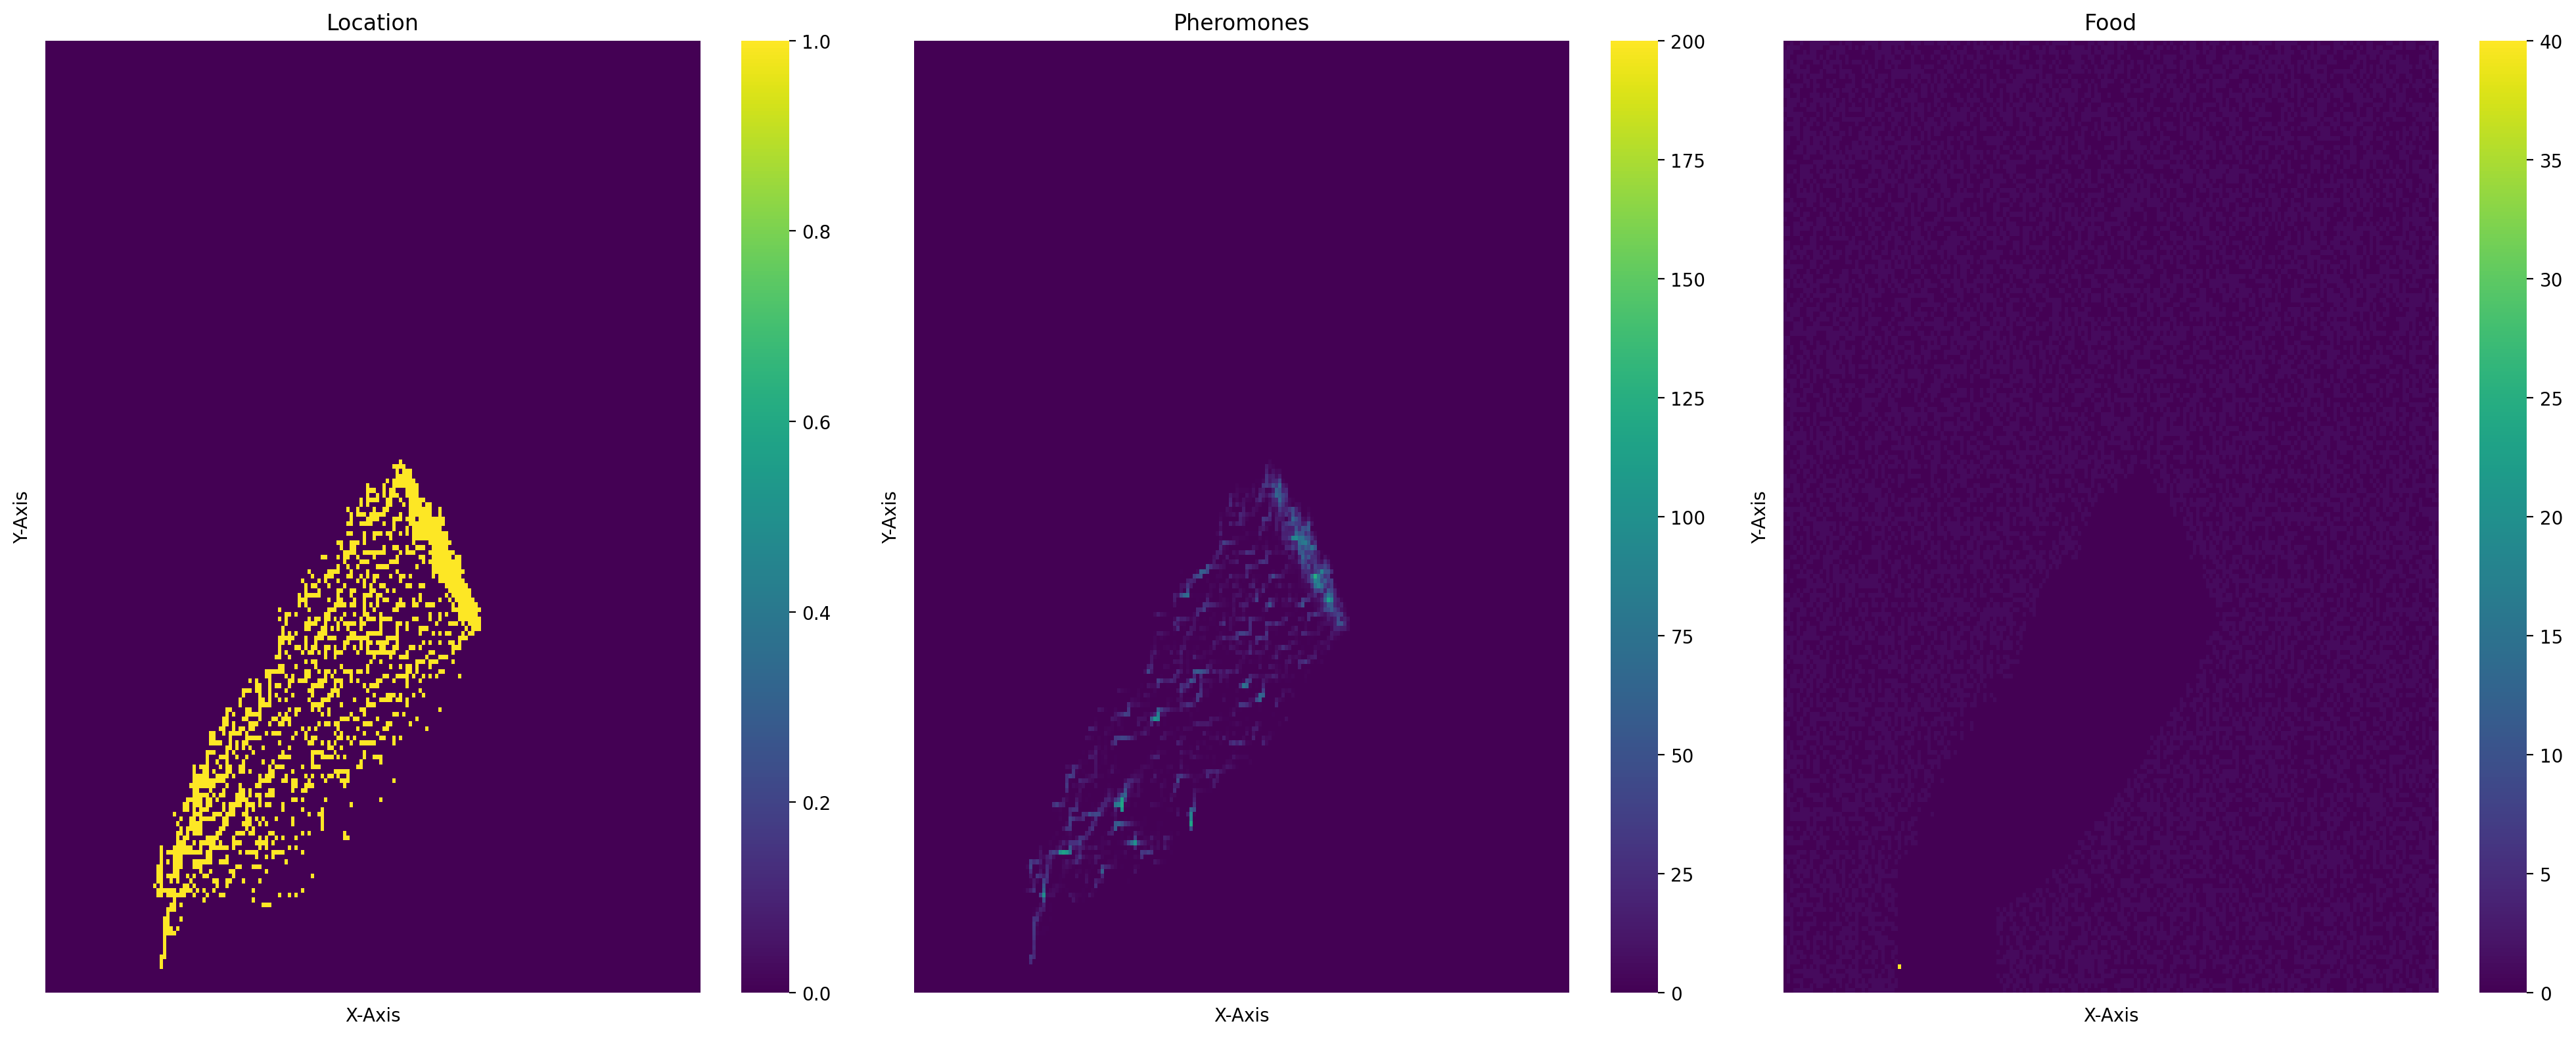

In [110]:
nodes, node_array = create_nodes(n=40000,experiment=2,randomise_capacity = True,terrain=False, nests=False,realistic_world=False, evaporation_rate=1/10)
new_nodes = model(nodes=nodes,steps=1000,ants_per_step=10,max_ants=4000)
multiplot(new_nodes,one=False,two=False,total=True,exp='0x00_rand')

Currently 2620 ants are searching for food and 1380 ants transport food back to the nest. 3632 food items are in the nest.


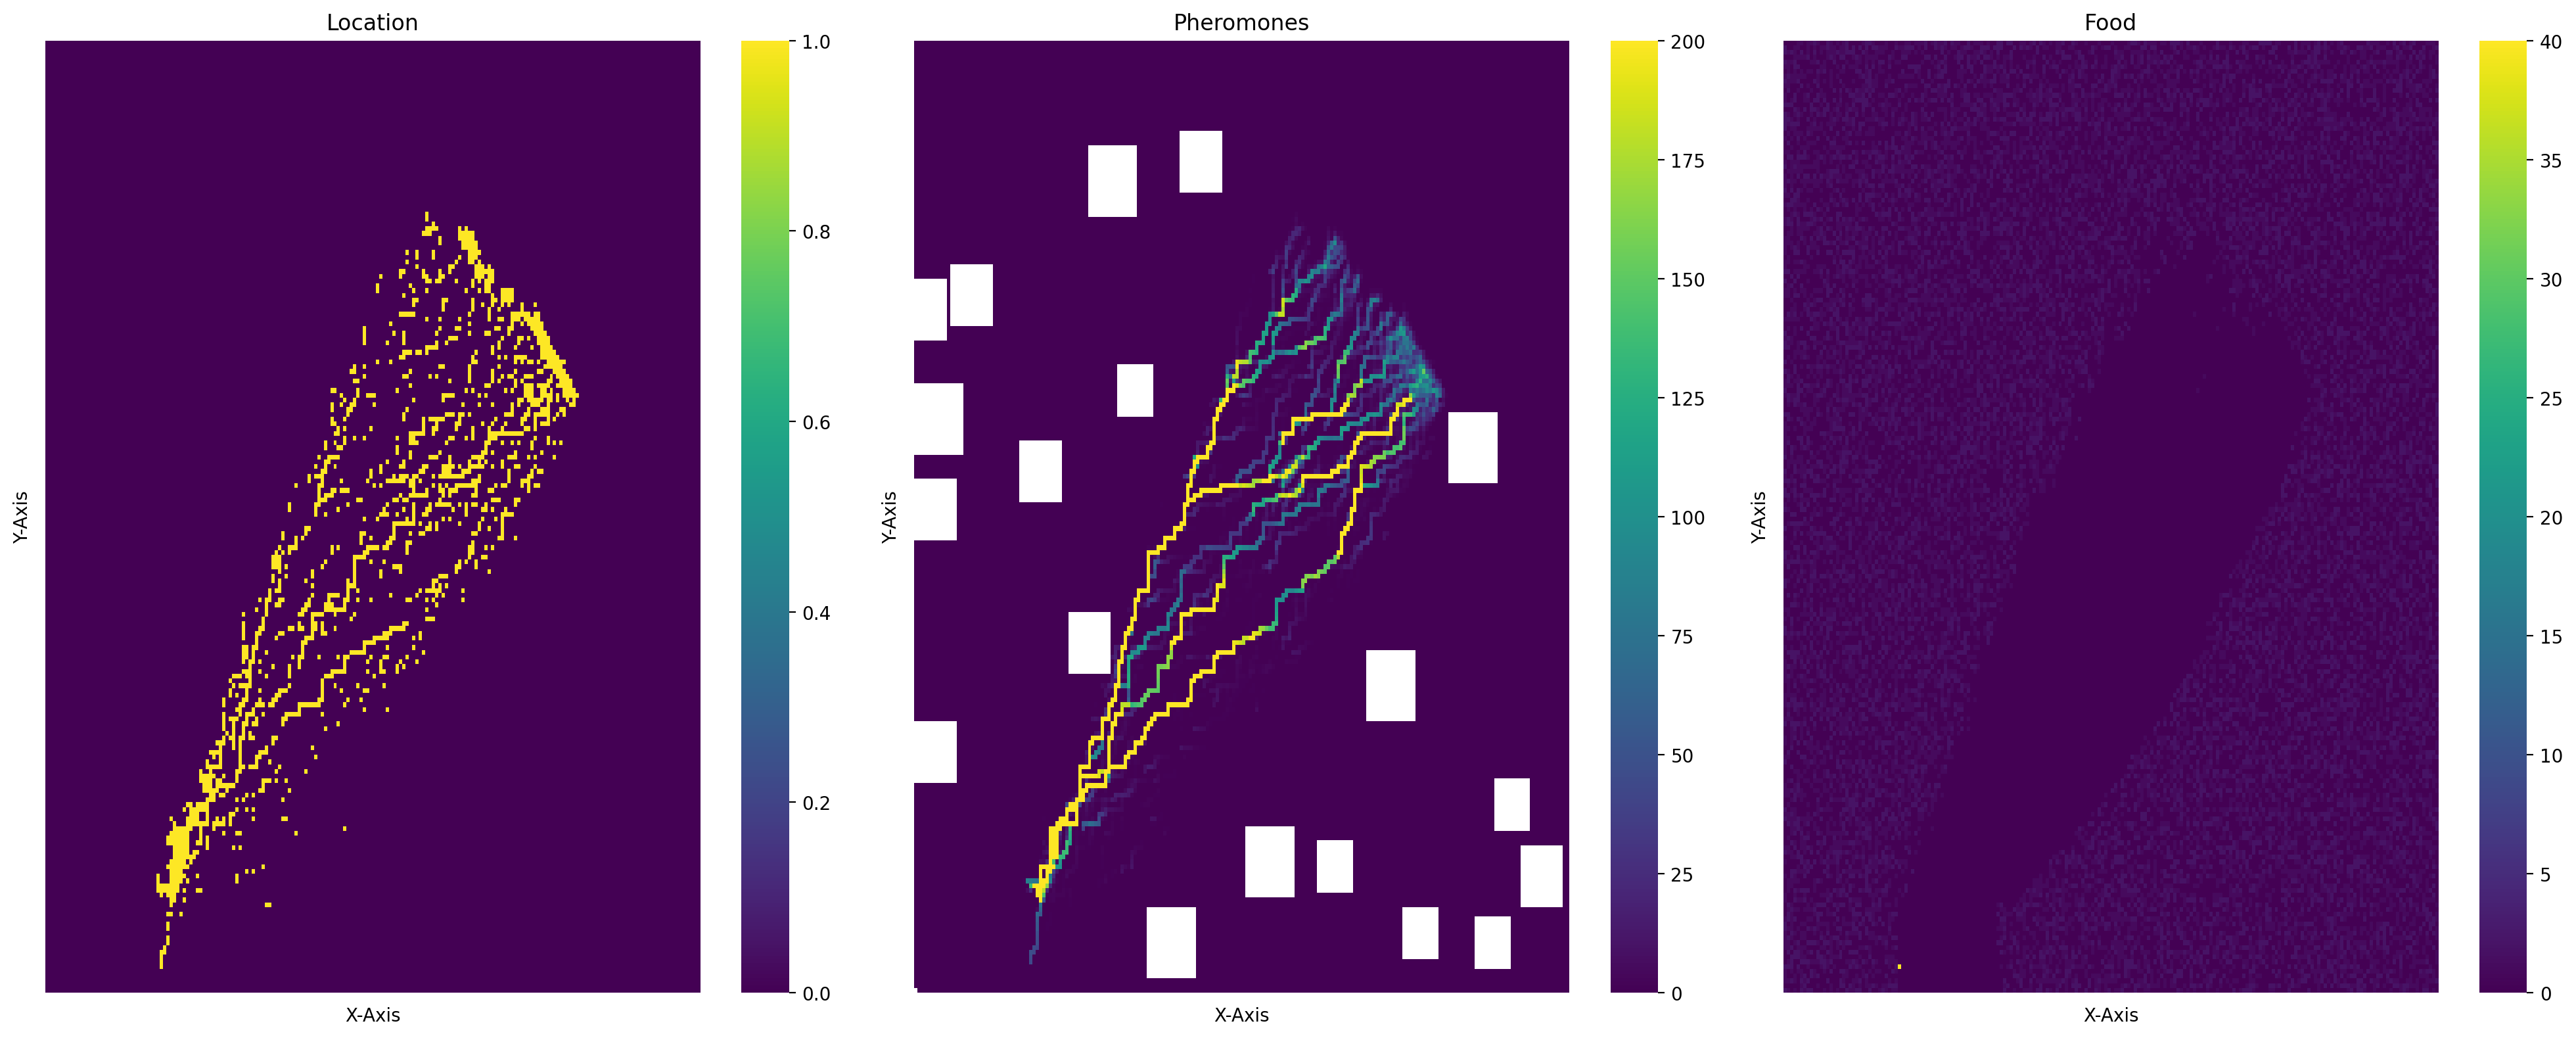

Currently 3061 ants are searching for food and 939 ants transport food back to the nest. 3059 food items are in the nest.


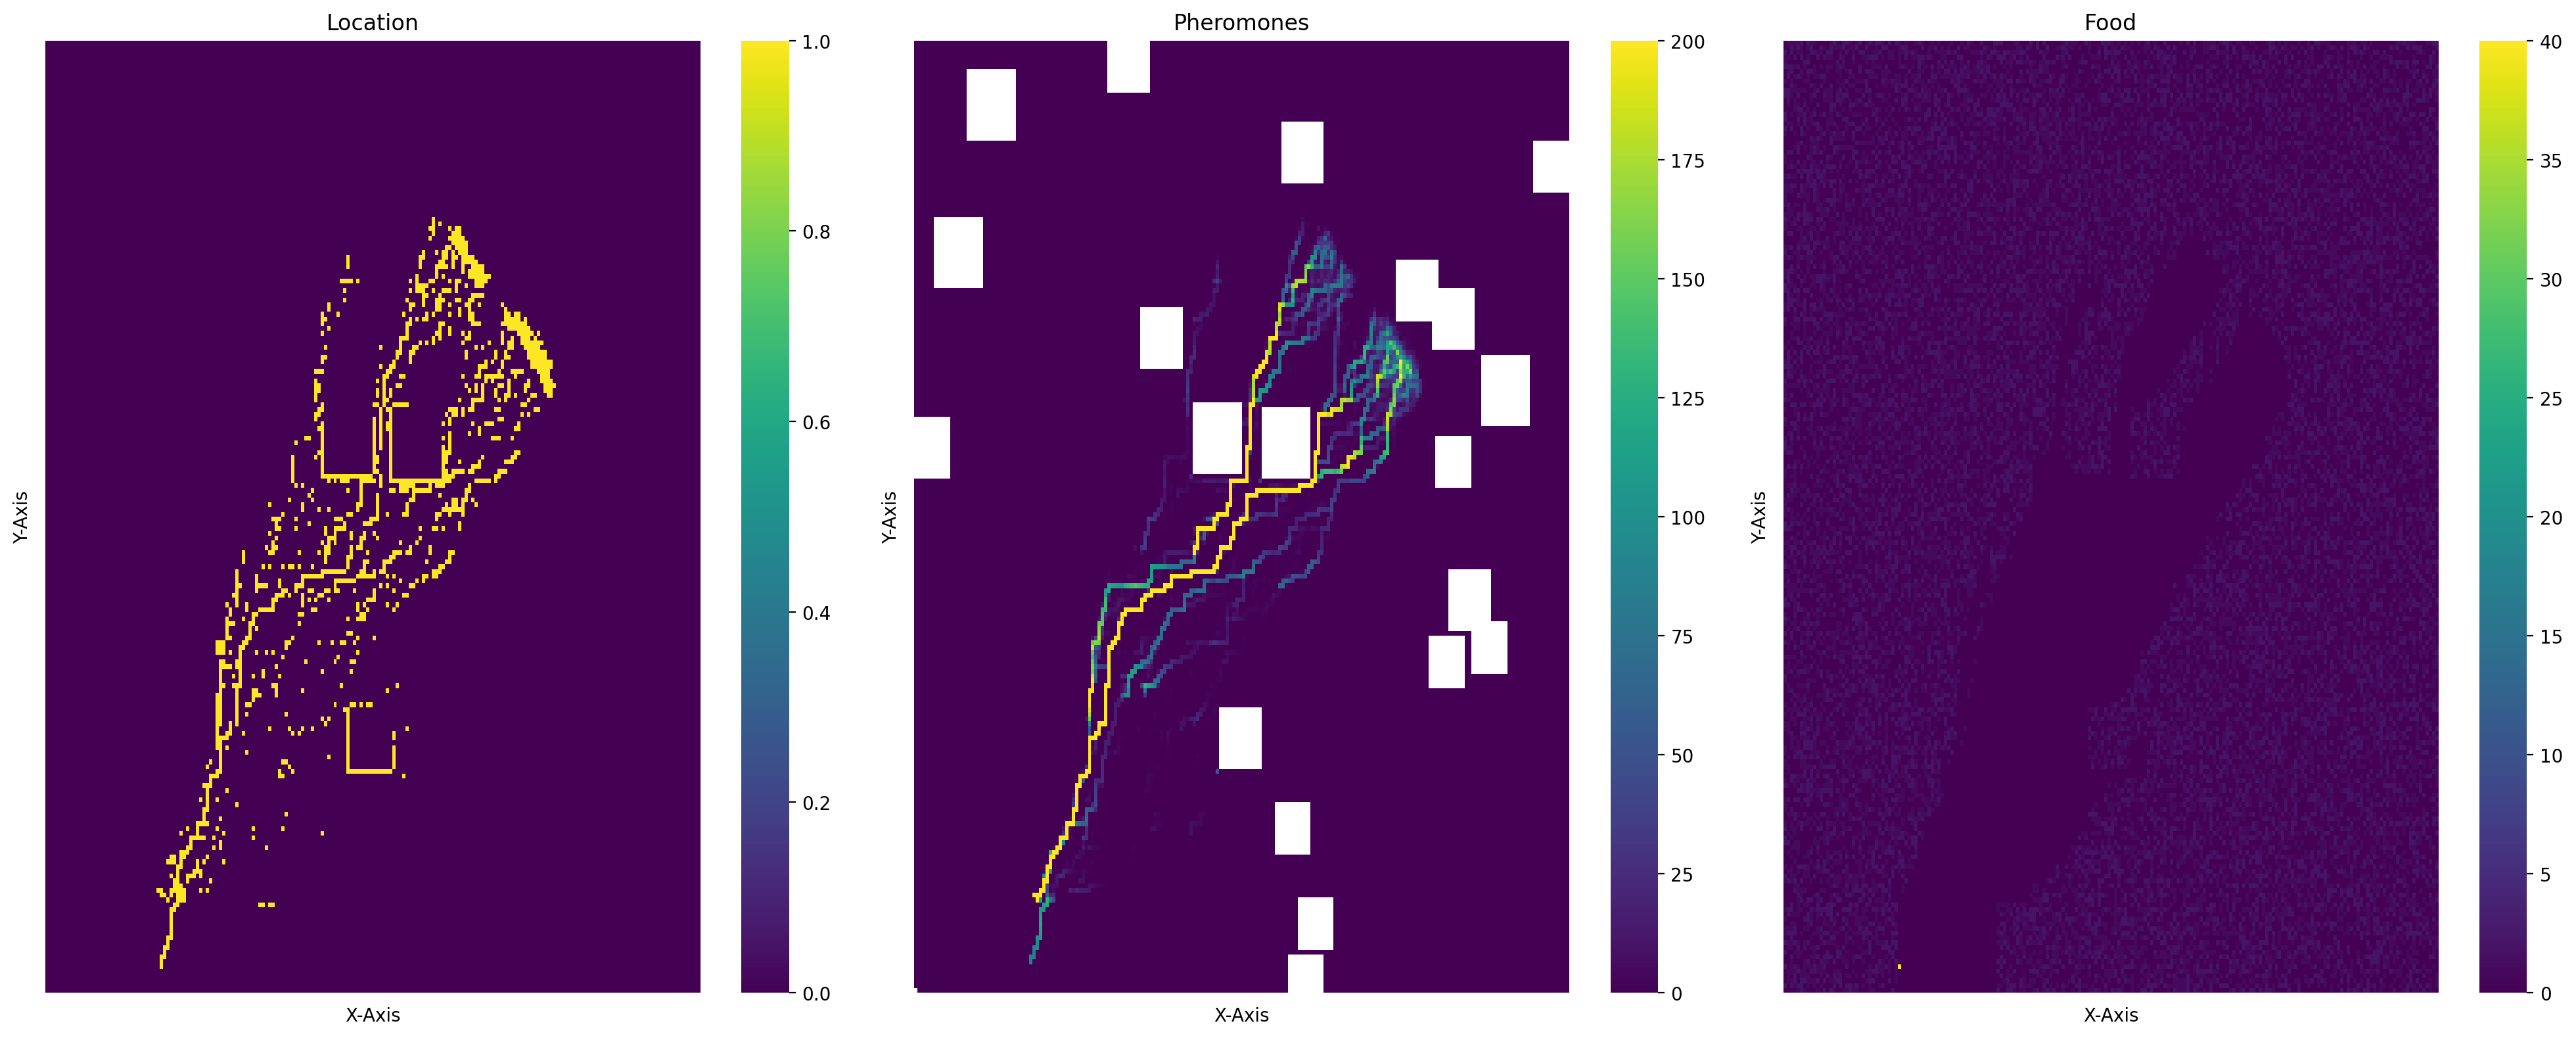

Currently 2848 ants are searching for food and 1152 ants transport food back to the nest. 3164 food items are in the nest.


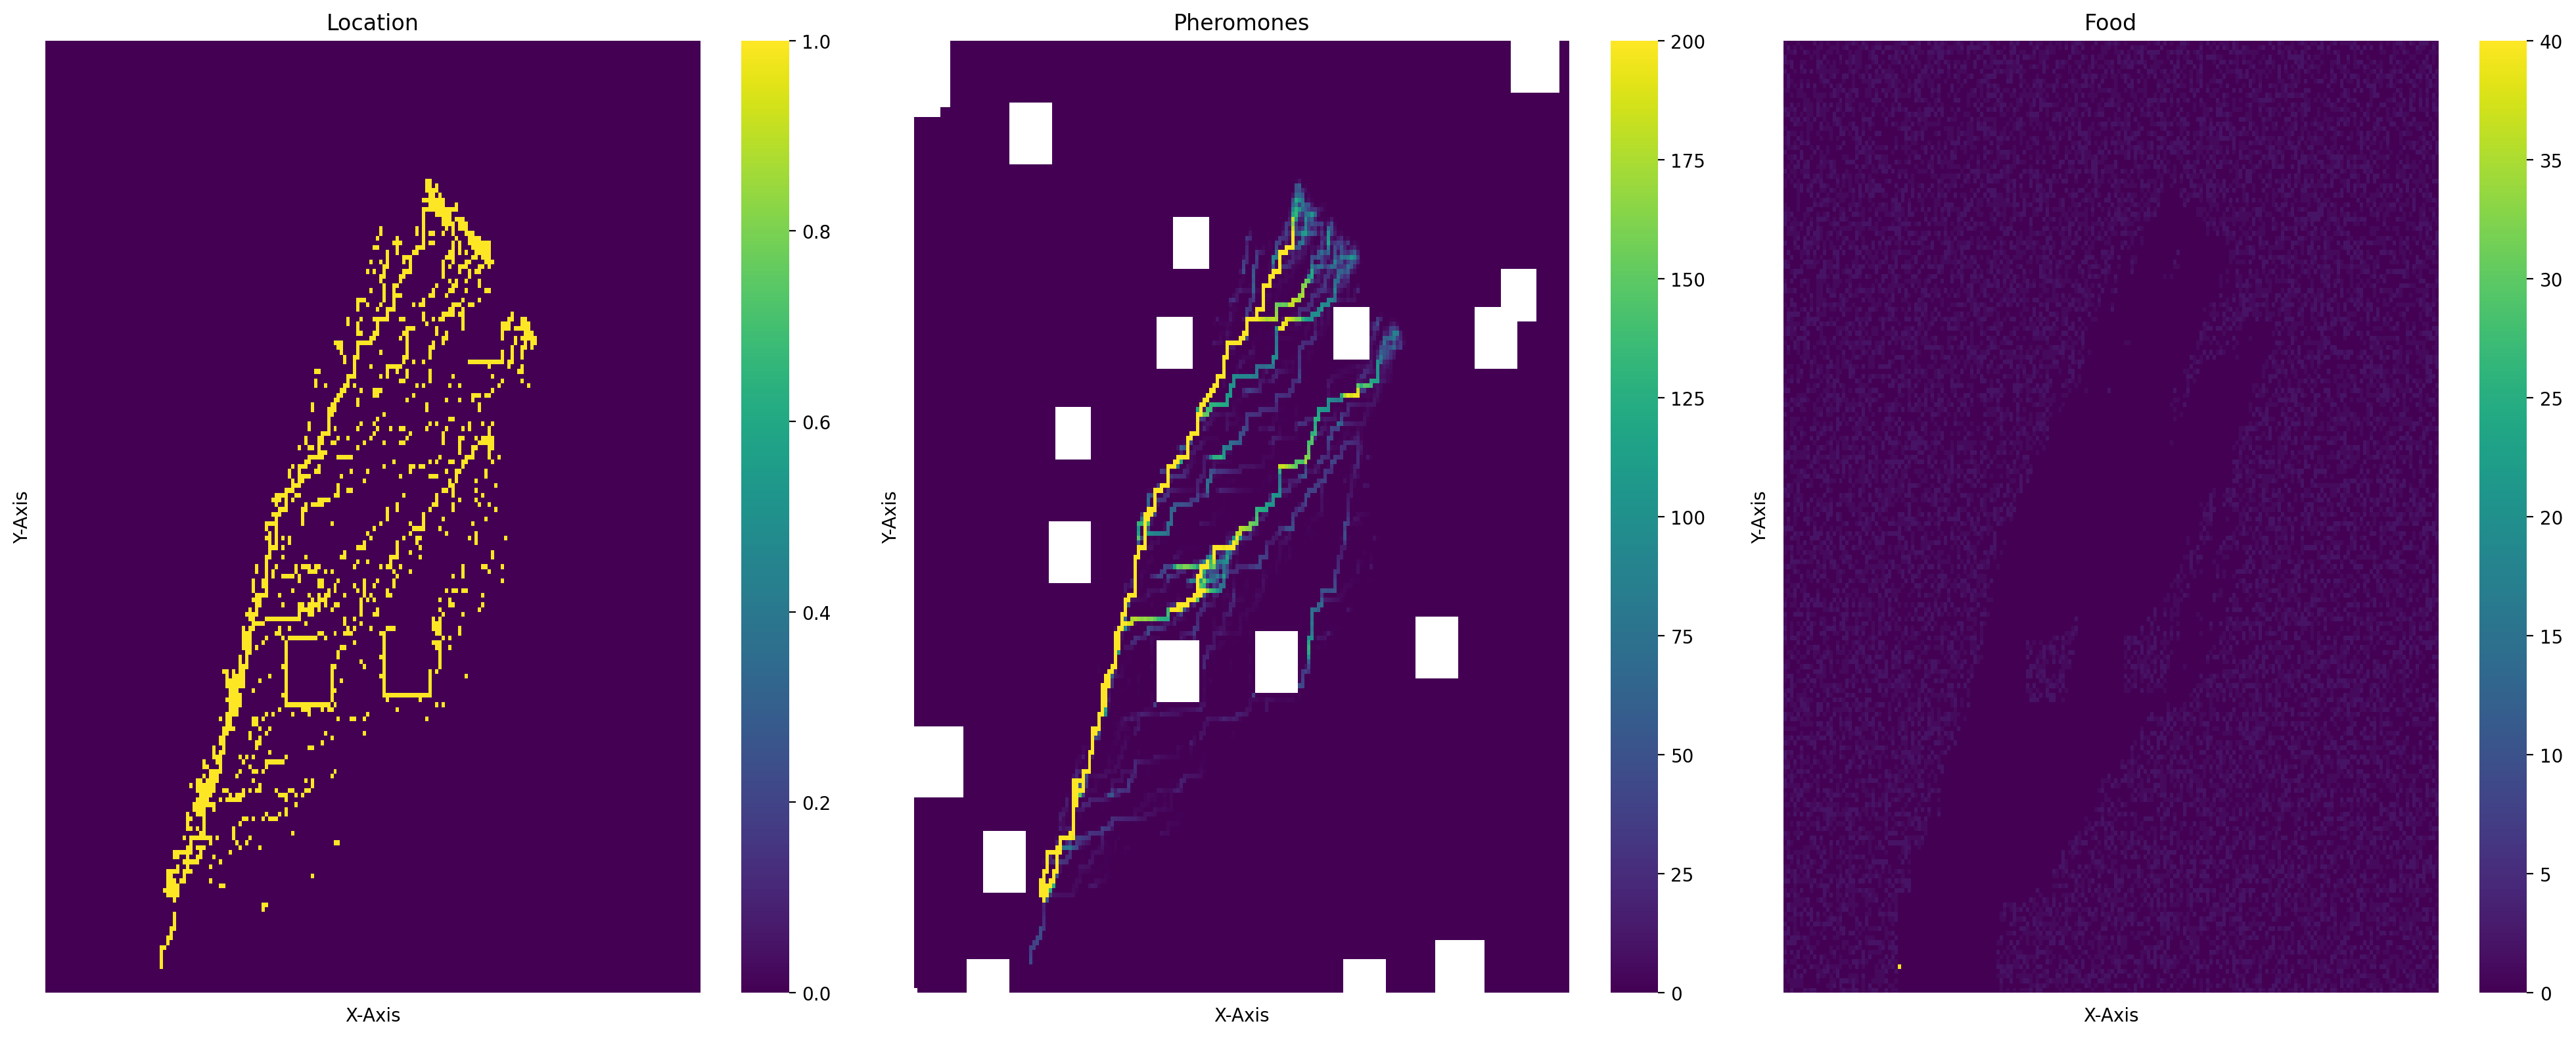

Currently 2721 ants are searching for food and 1279 ants transport food back to the nest. 2972 food items are in the nest.


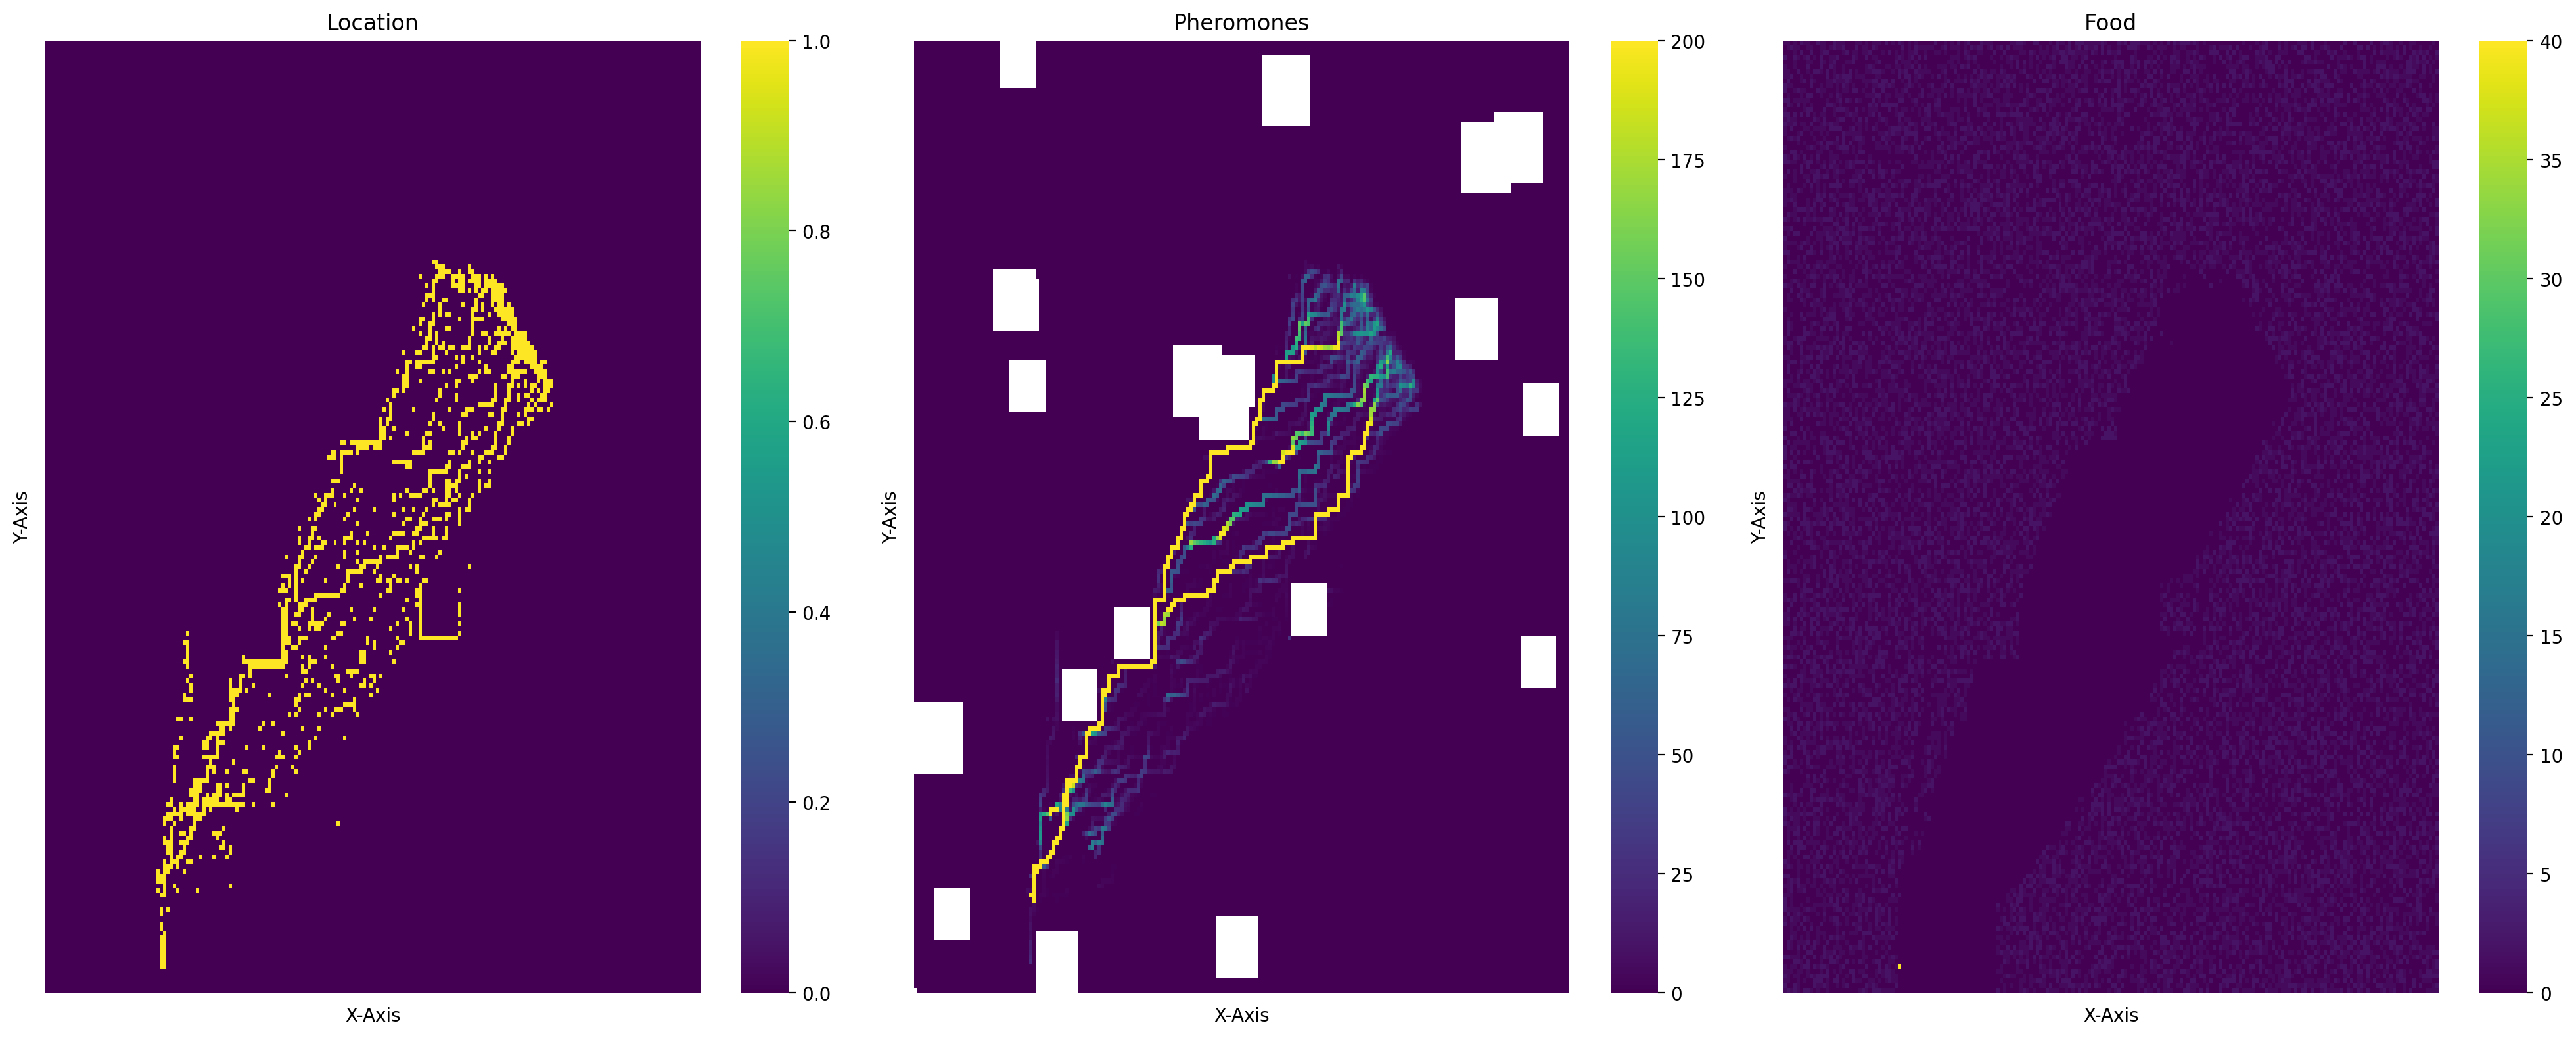

Currently 2914 ants are searching for food and 1086 ants transport food back to the nest. 3323 food items are in the nest.


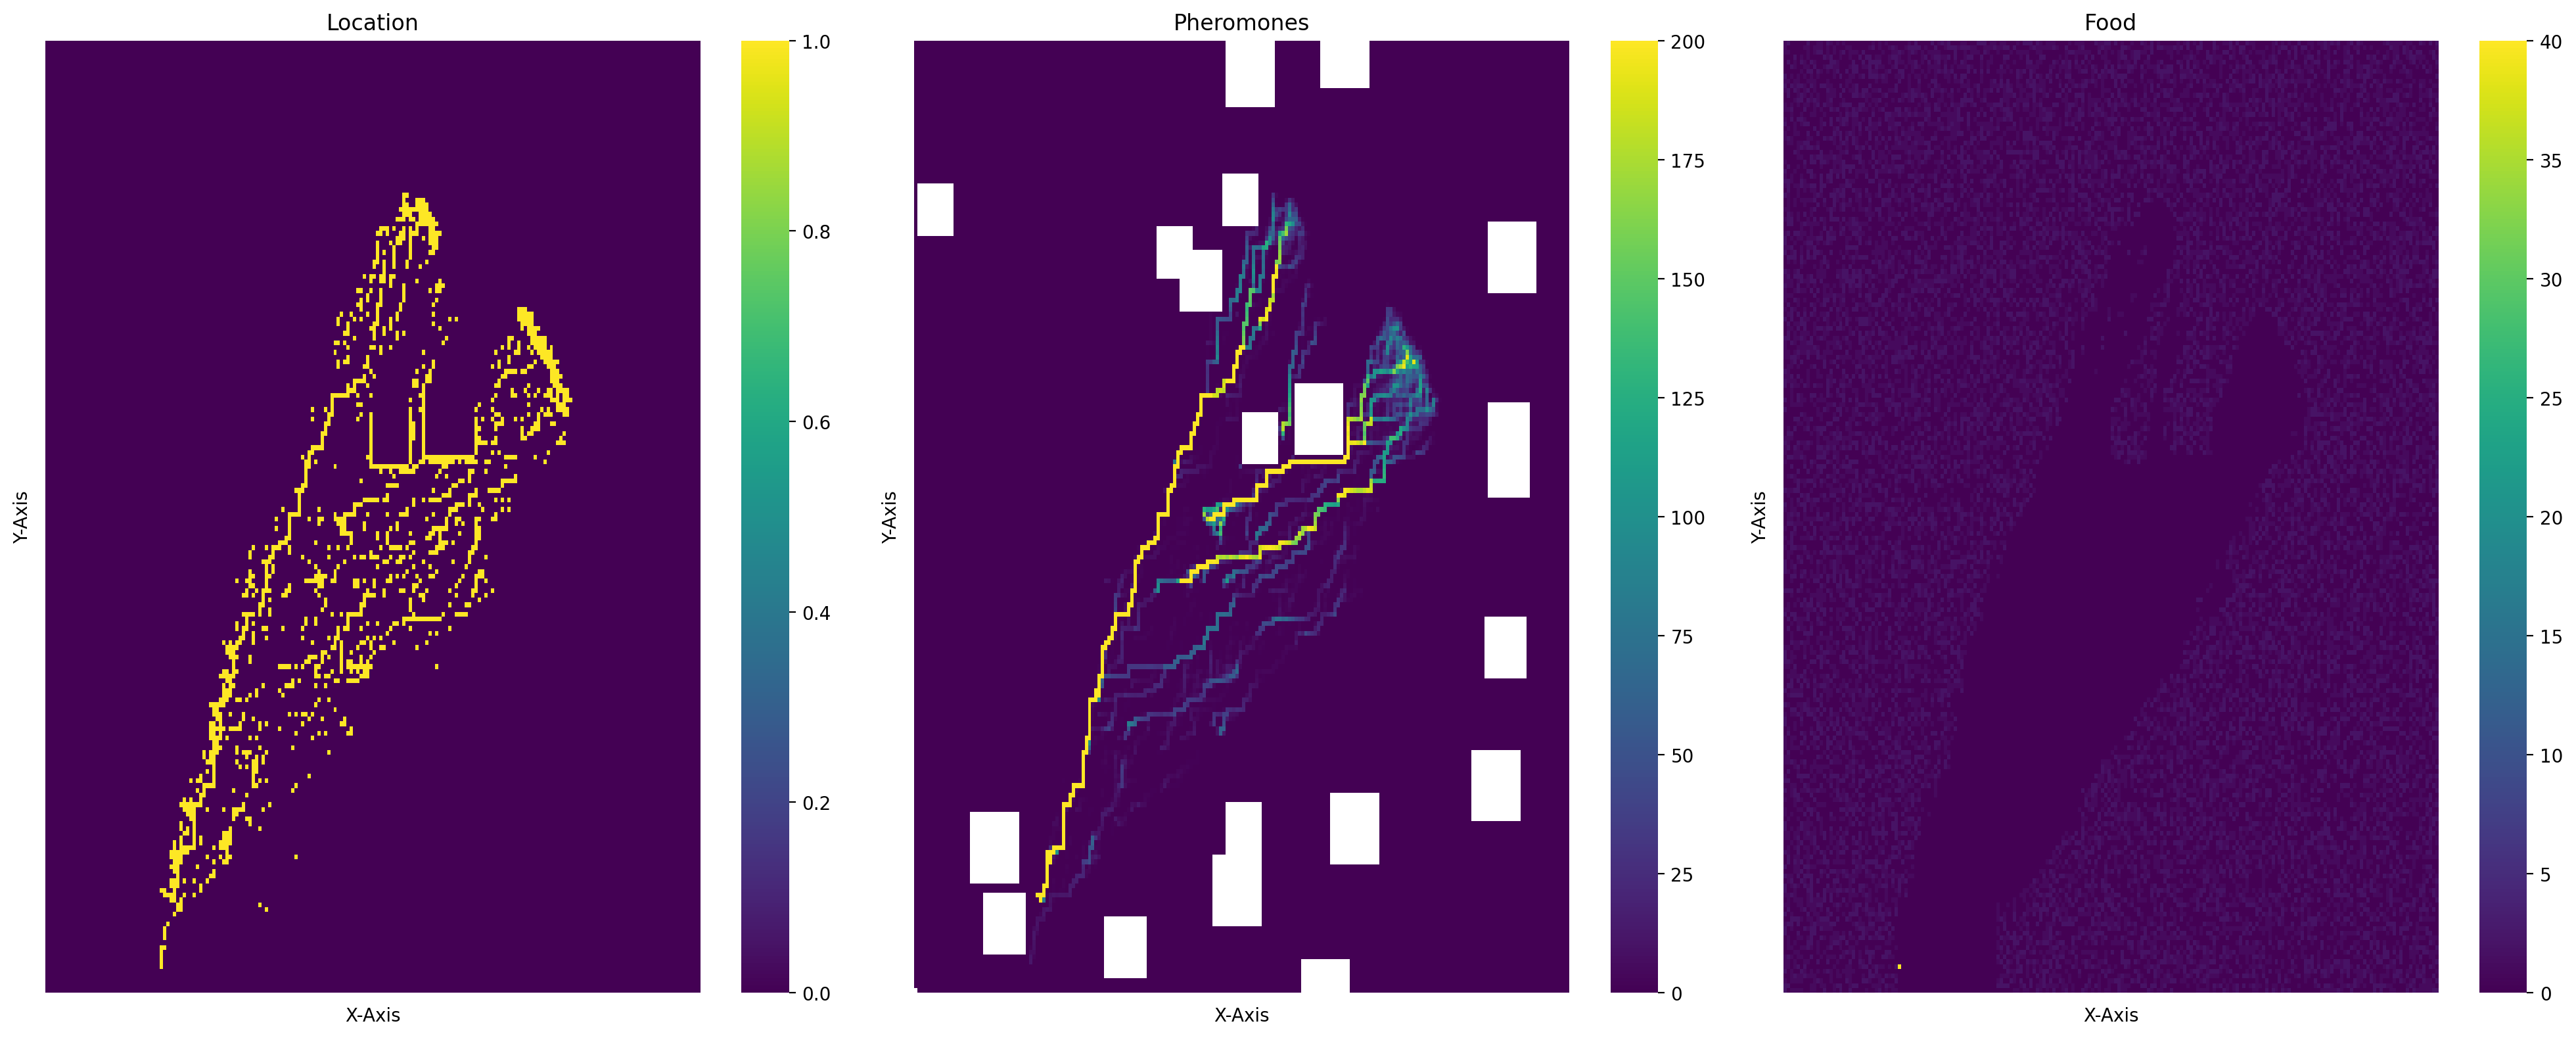

Currently 2792 ants are searching for food and 1208 ants transport food back to the nest. 3328 food items are in the nest.


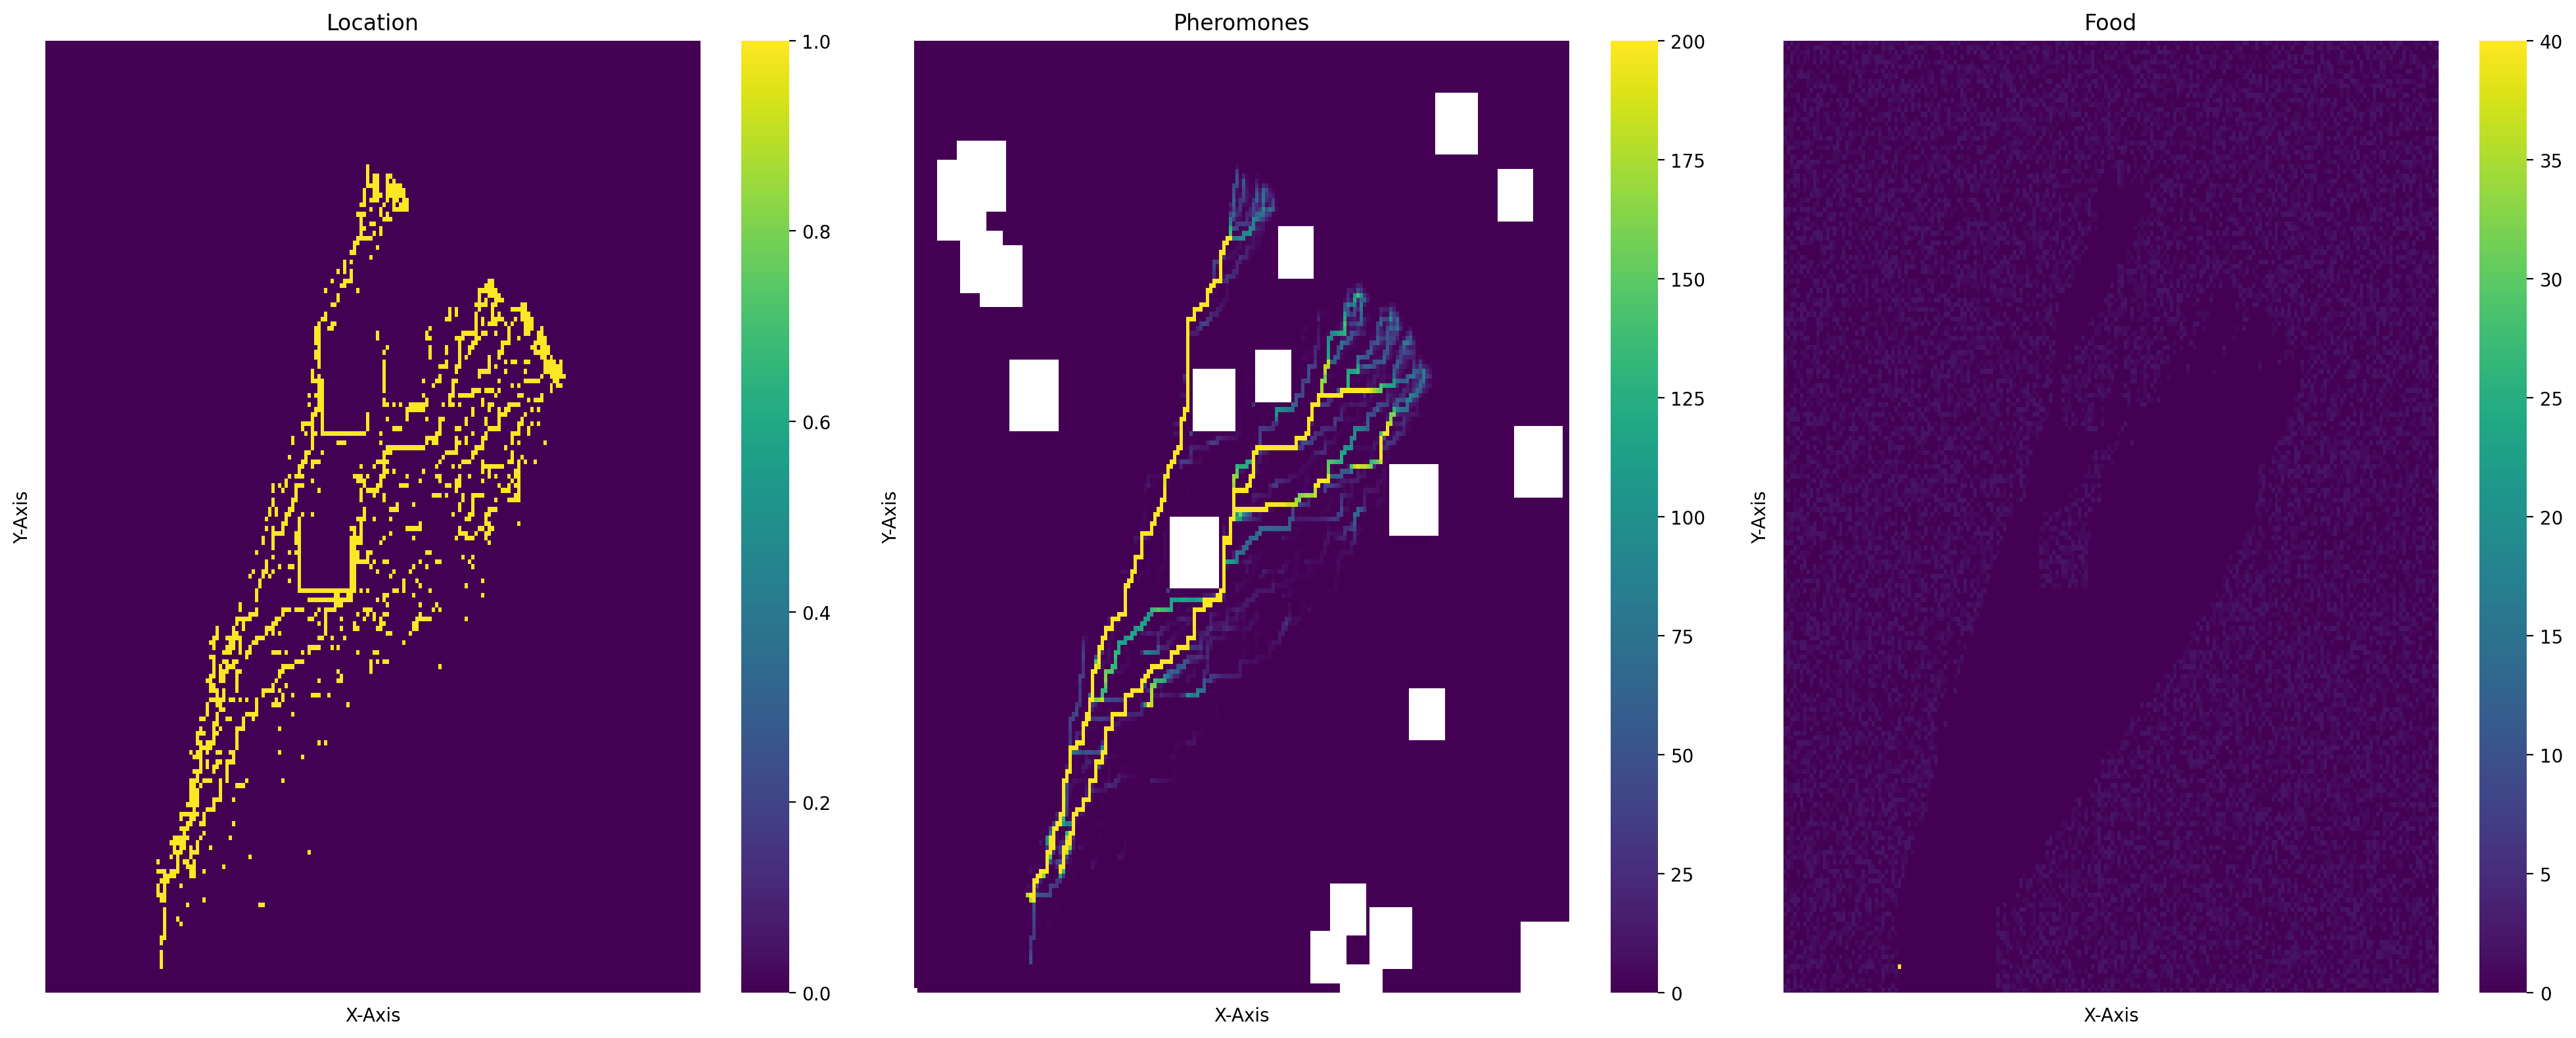

Currently 3010 ants are searching for food and 990 ants transport food back to the nest. 2056 food items are in the nest.


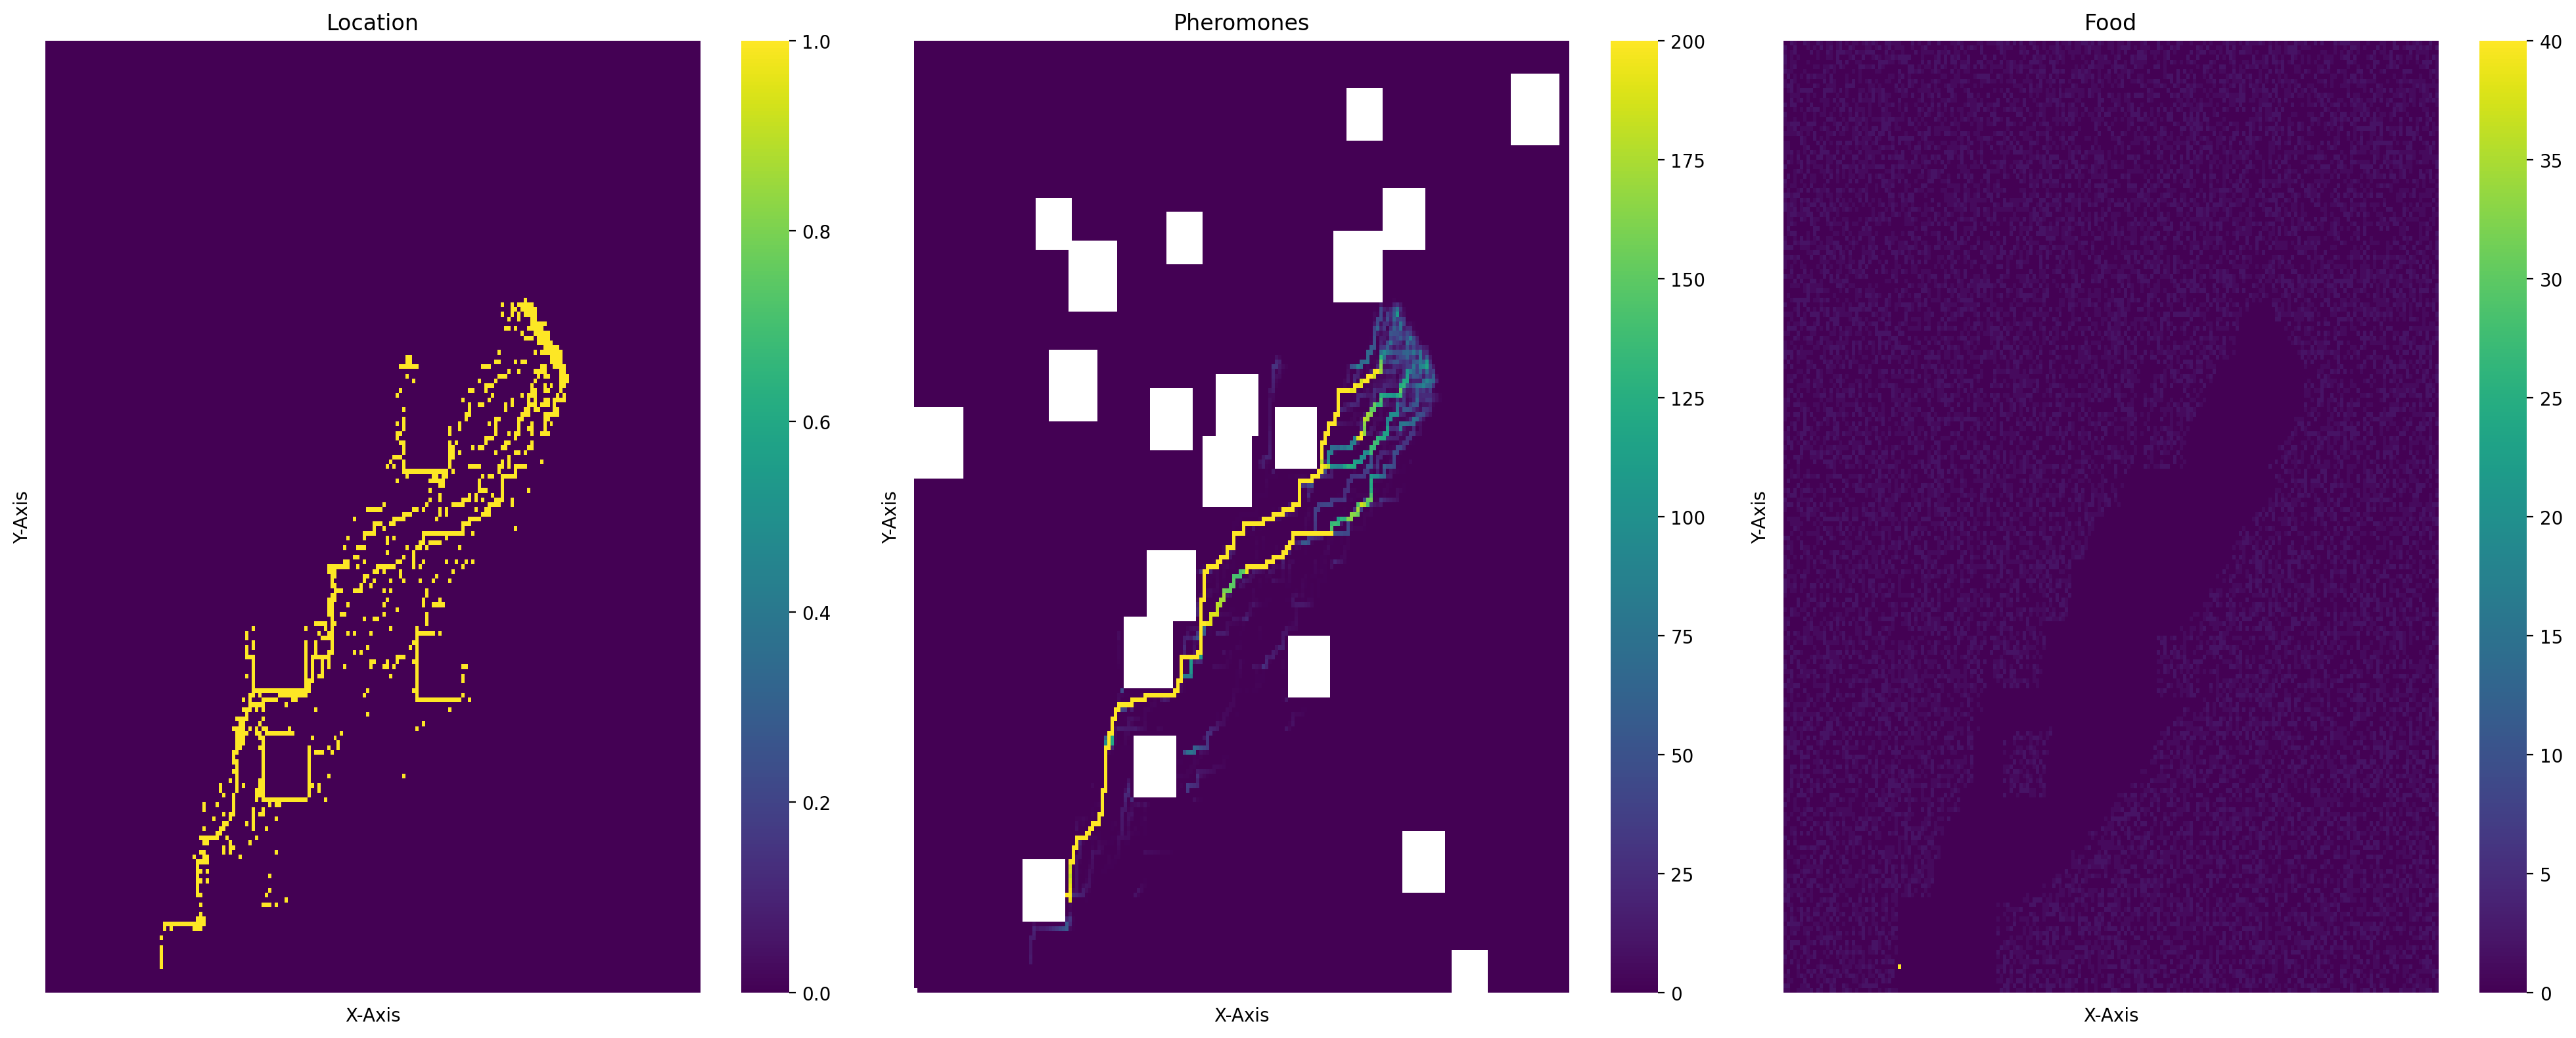

Currently 2619 ants are searching for food and 1381 ants transport food back to the nest. 3116 food items are in the nest.


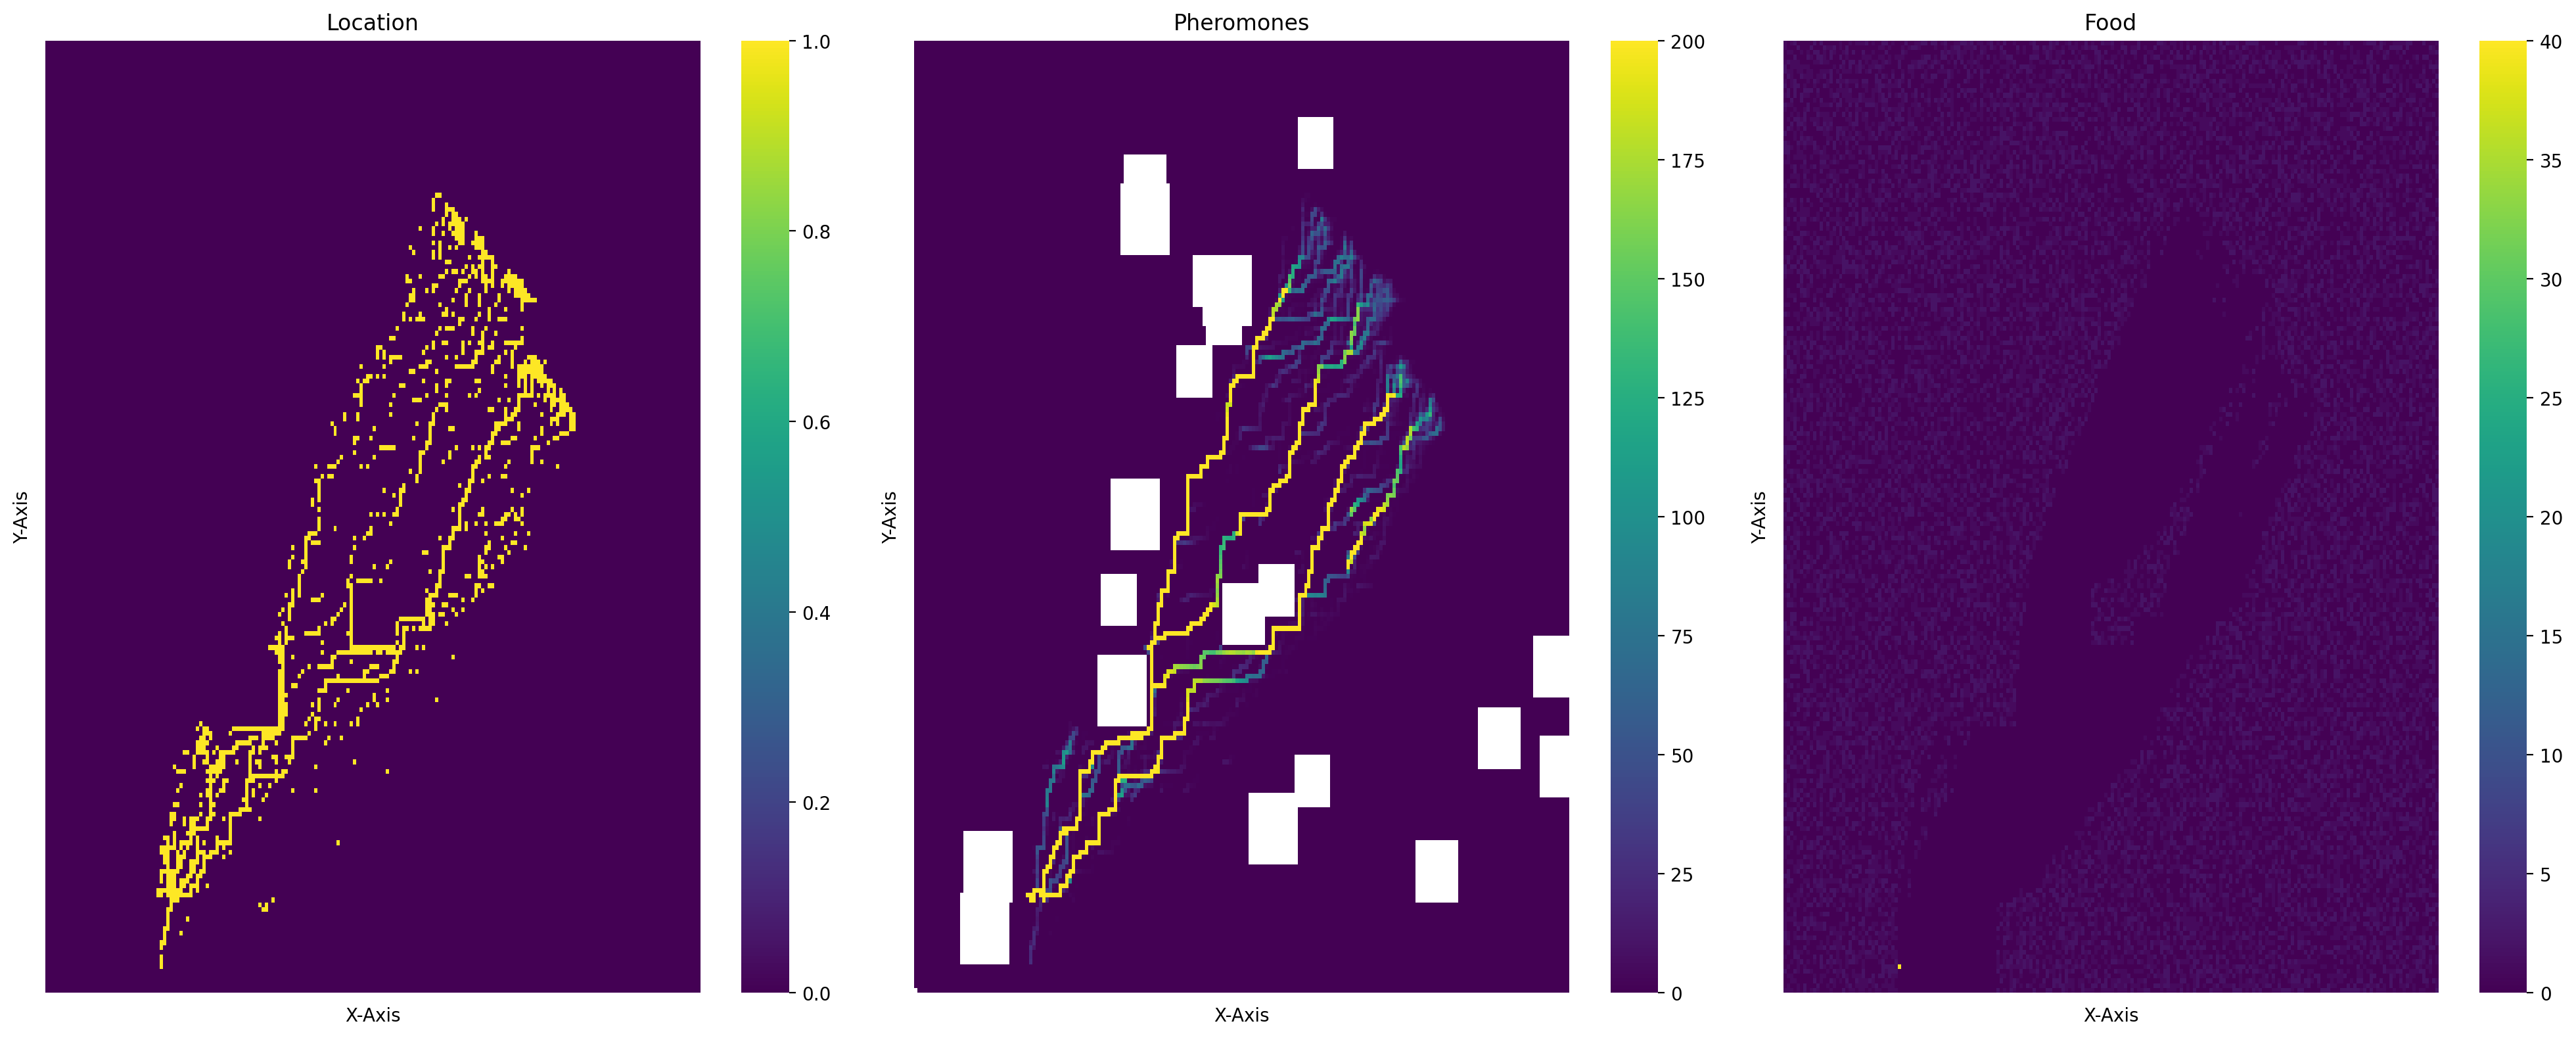

Currently 2989 ants are searching for food and 1011 ants transport food back to the nest. 3217 food items are in the nest.


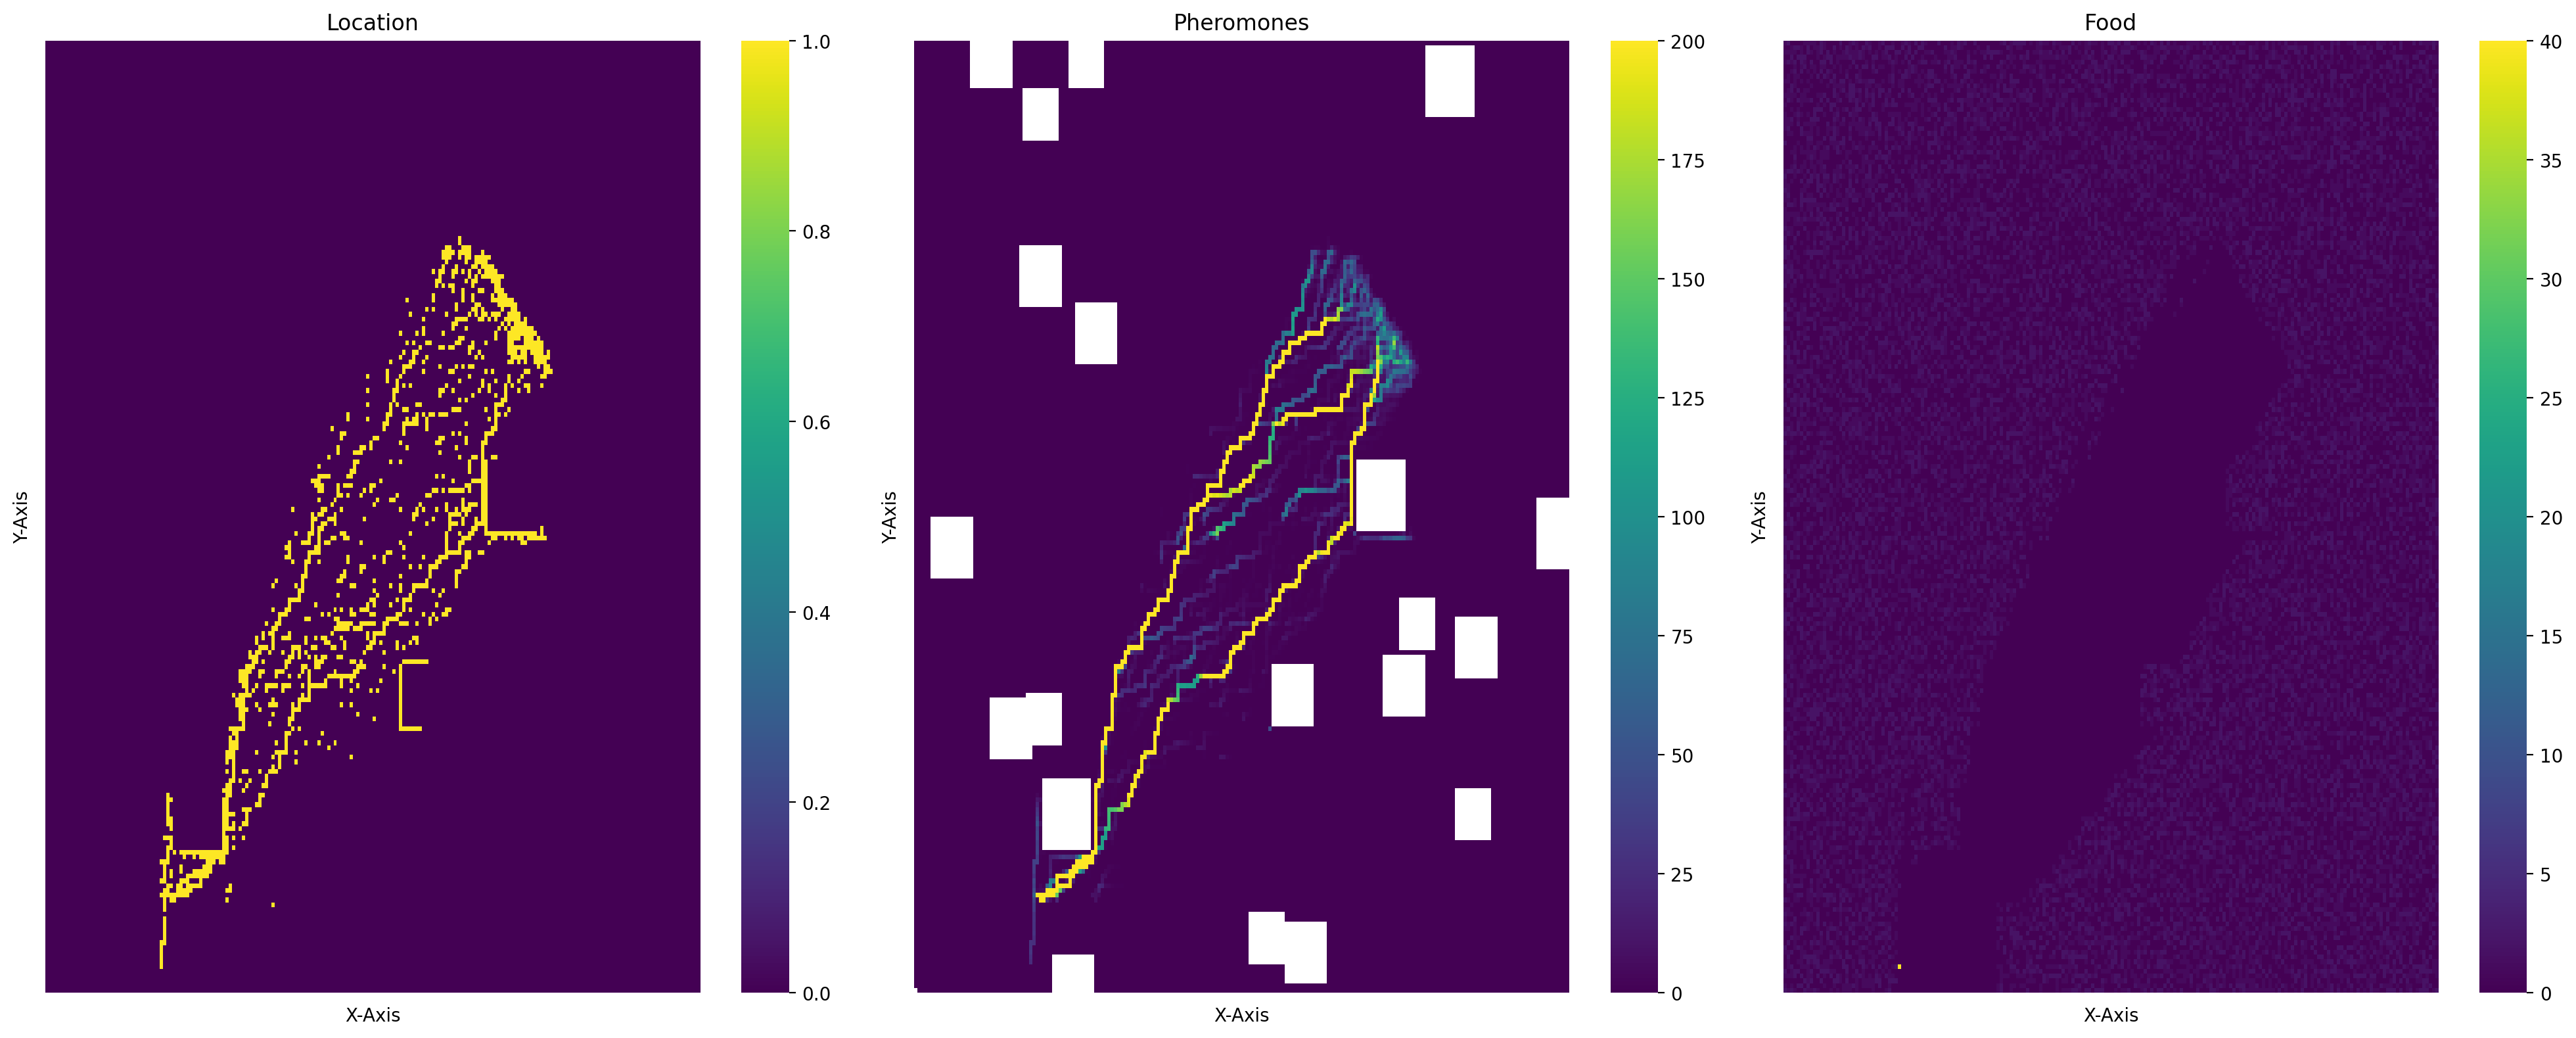

Currently 3042 ants are searching for food and 958 ants transport food back to the nest. 2087 food items are in the nest.


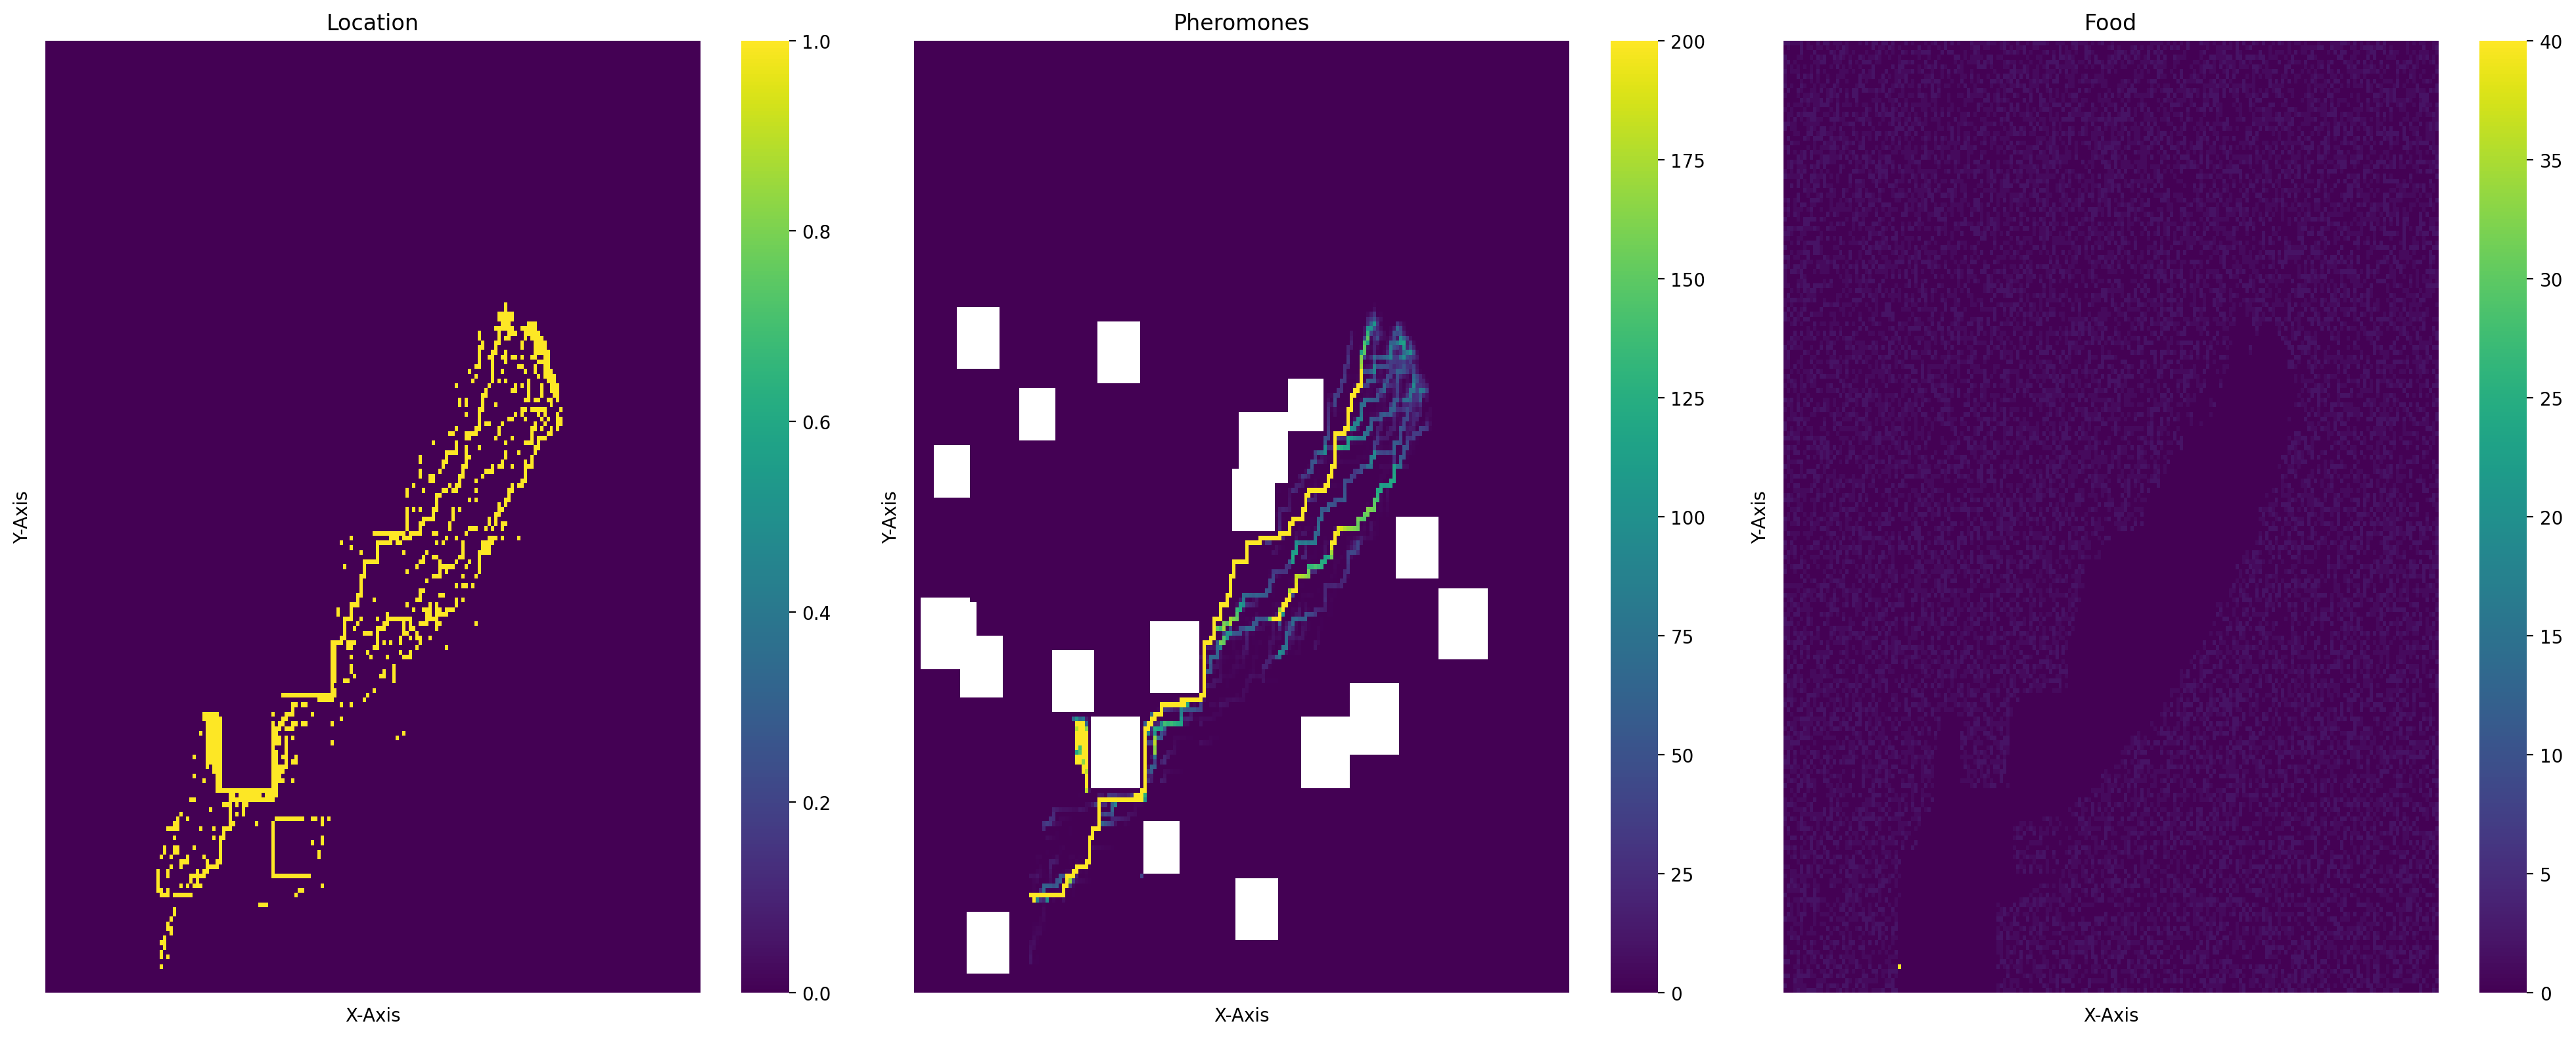

Currently 3059 ants are searching for food and 941 ants transport food back to the nest. 2310 food items are in the nest.


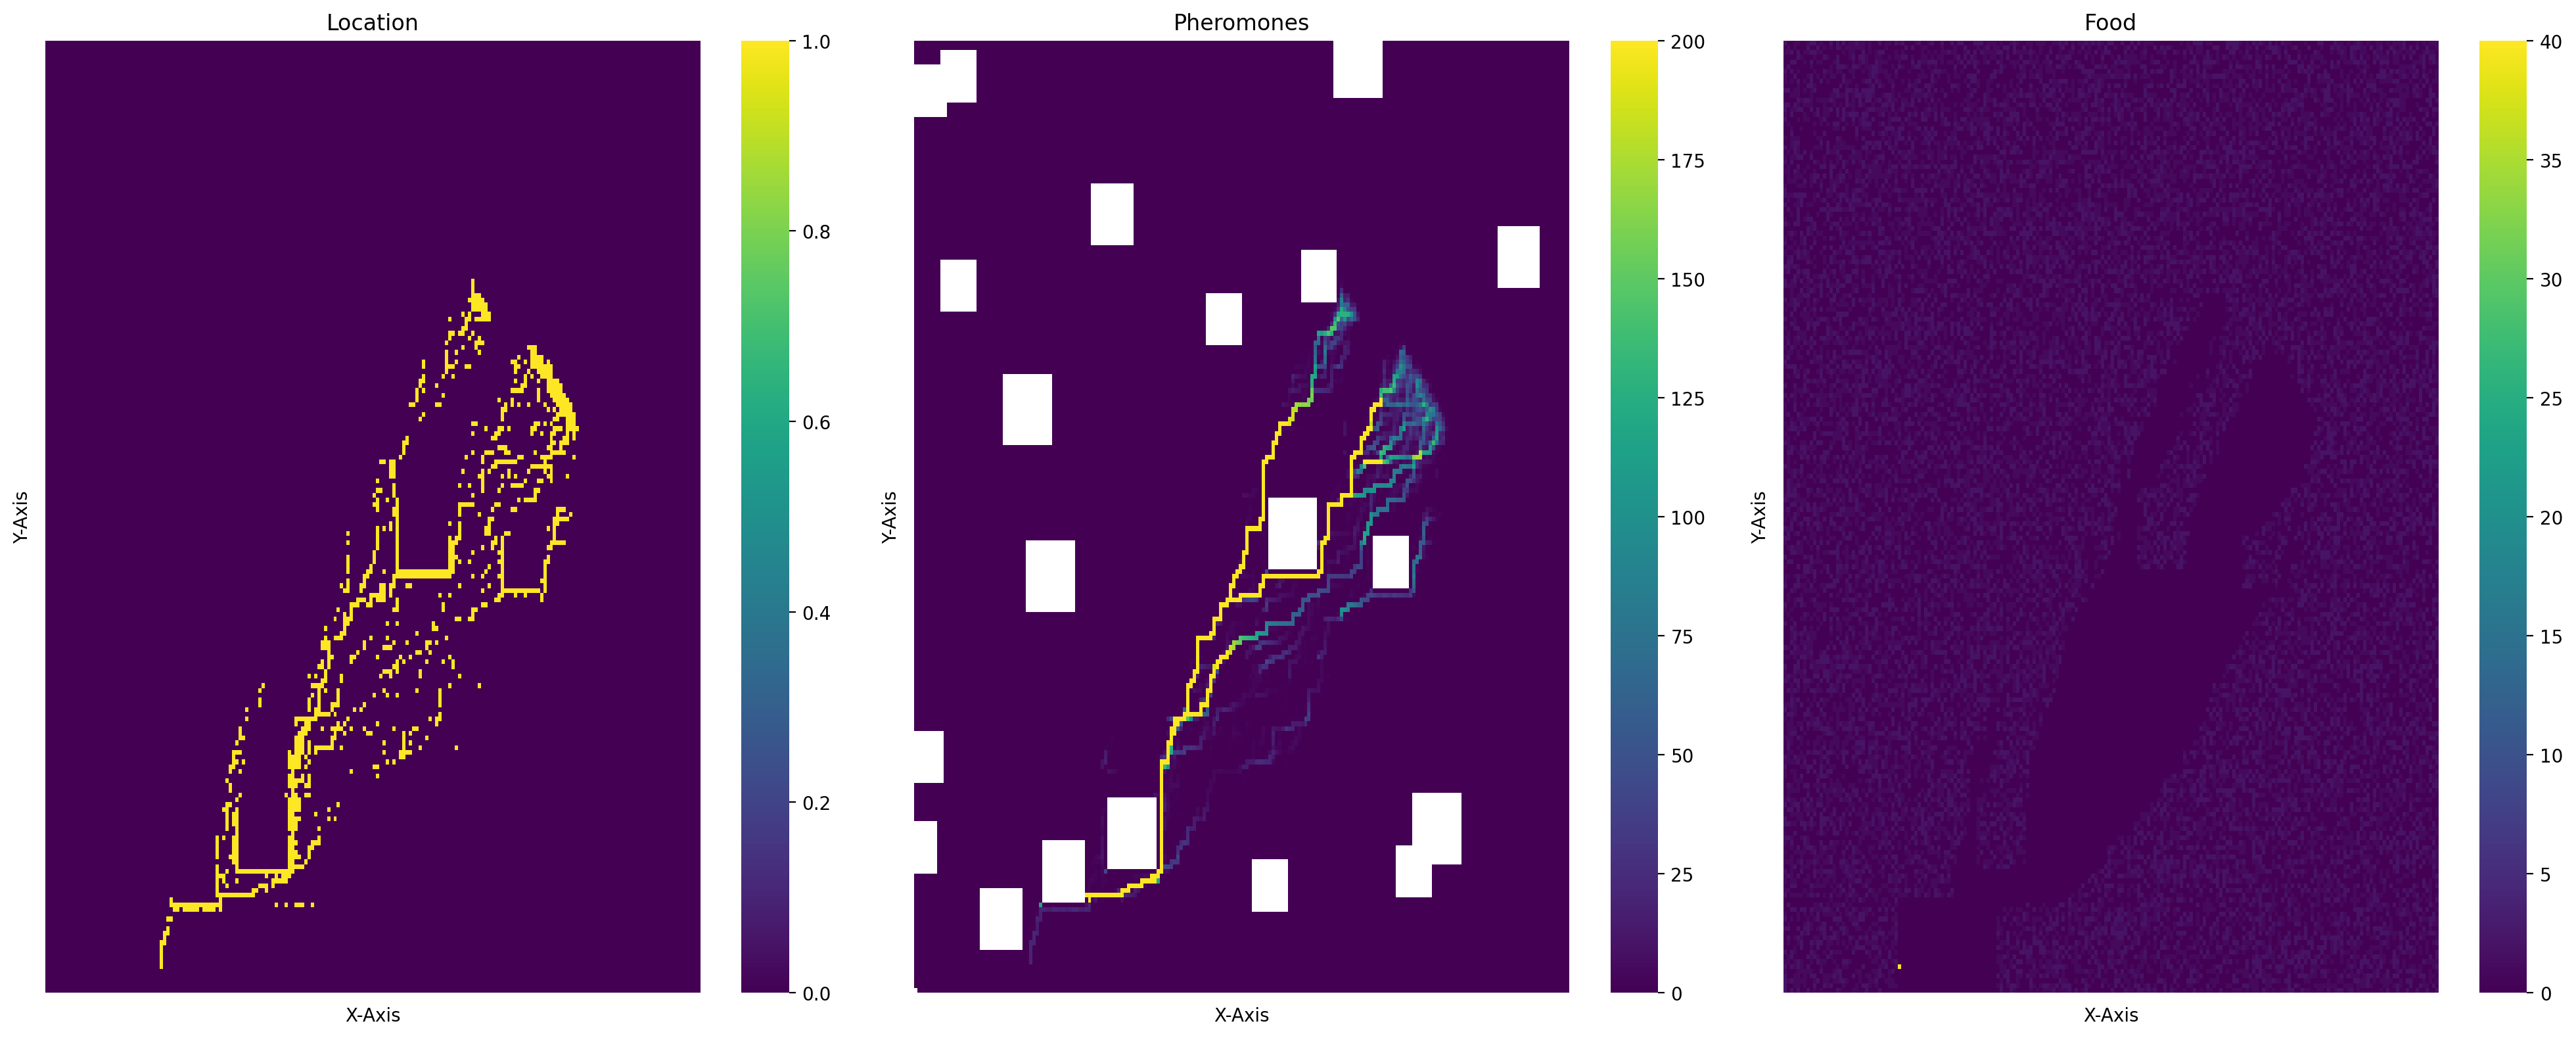

Currently 2800 ants are searching for food and 1200 ants transport food back to the nest. 3491 food items are in the nest.


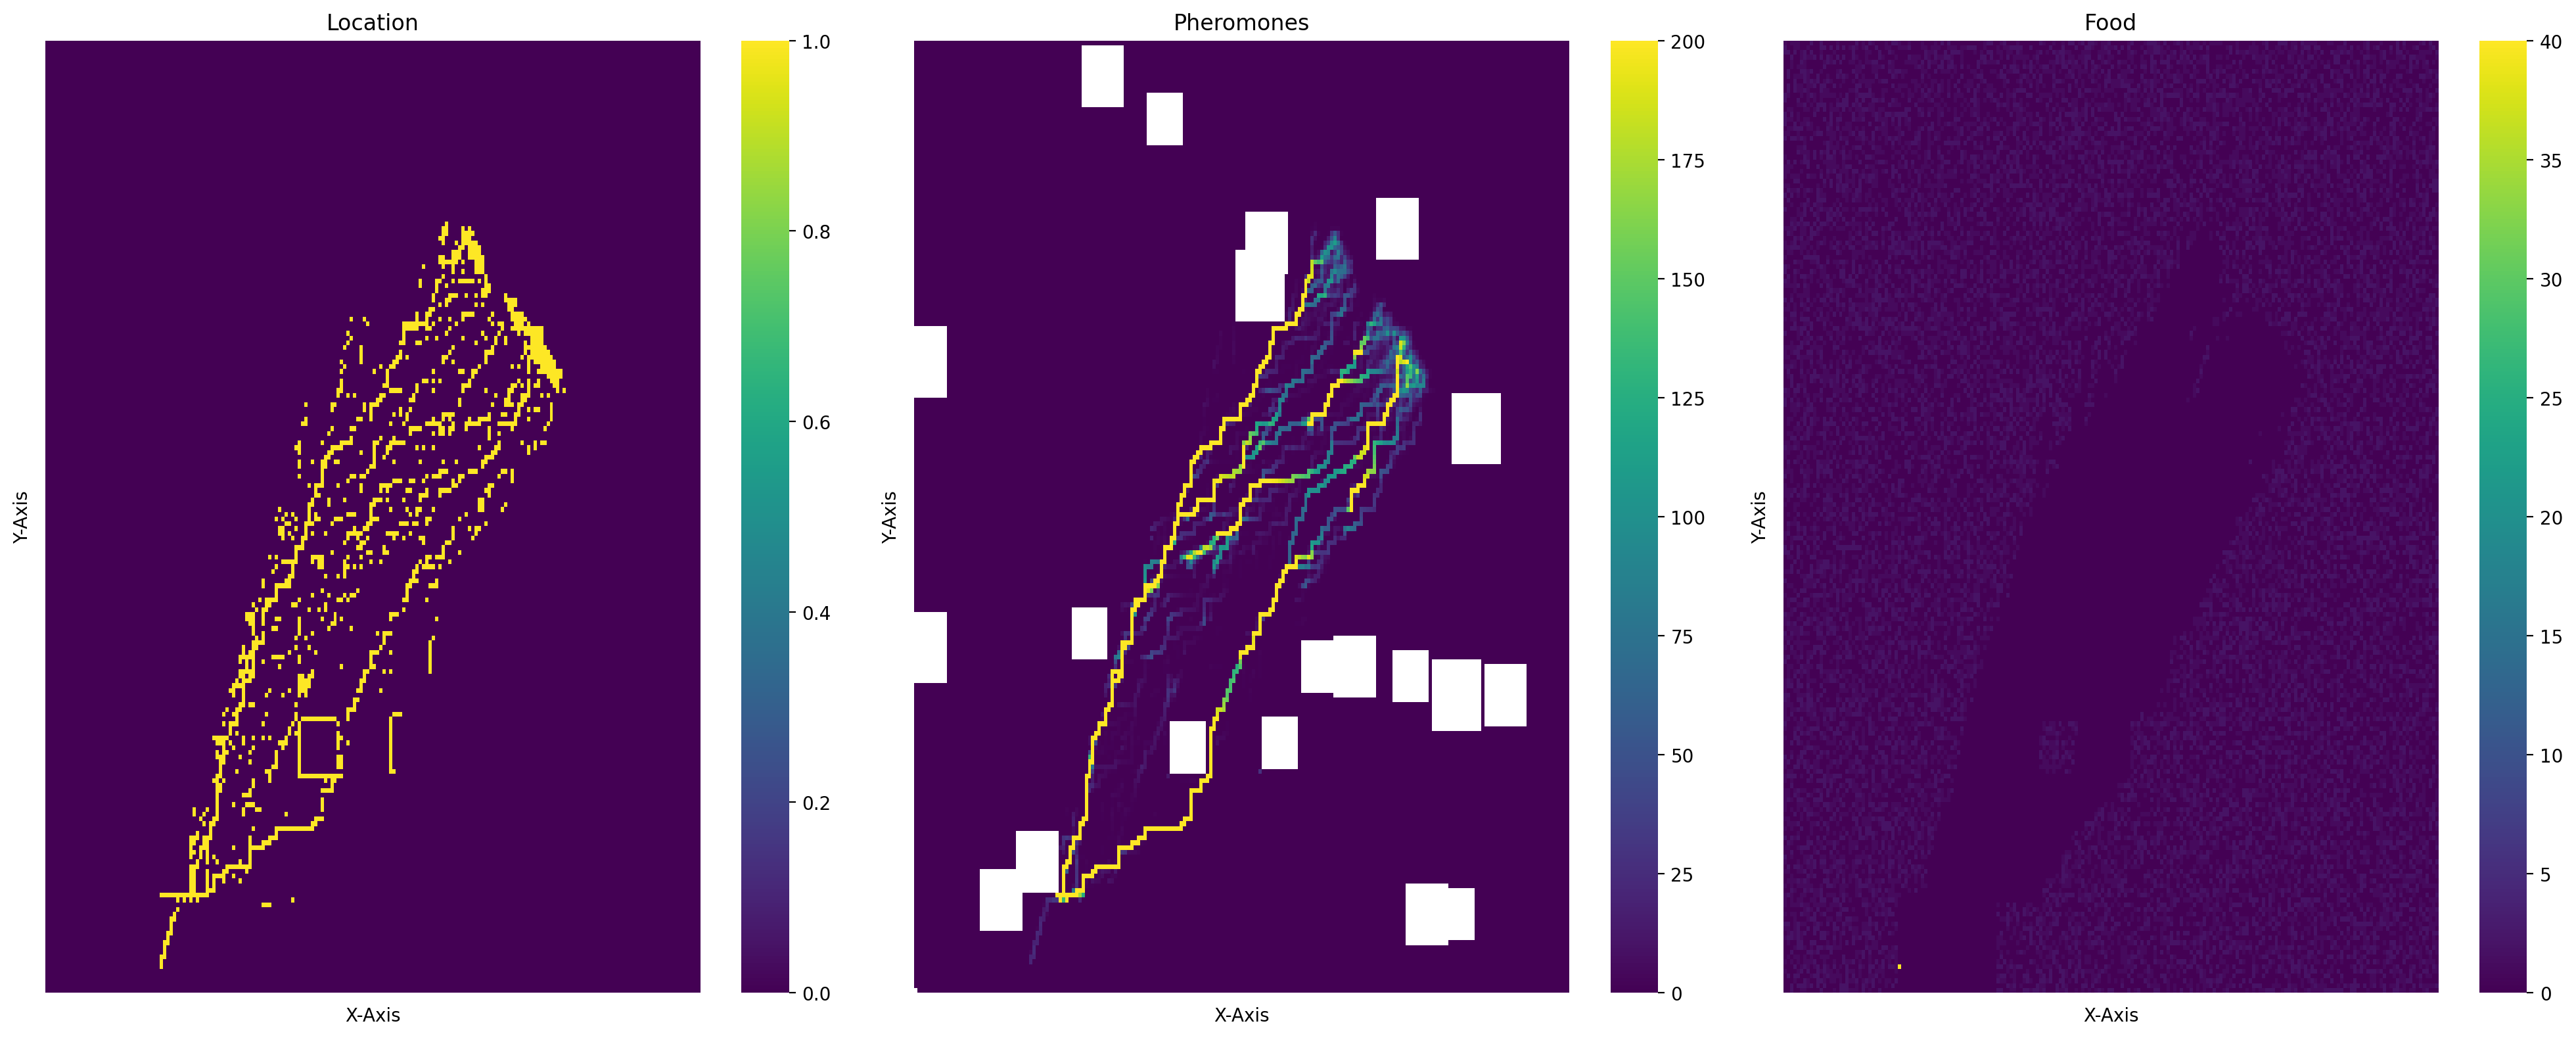

Currently 2725 ants are searching for food and 1275 ants transport food back to the nest. 2782 food items are in the nest.


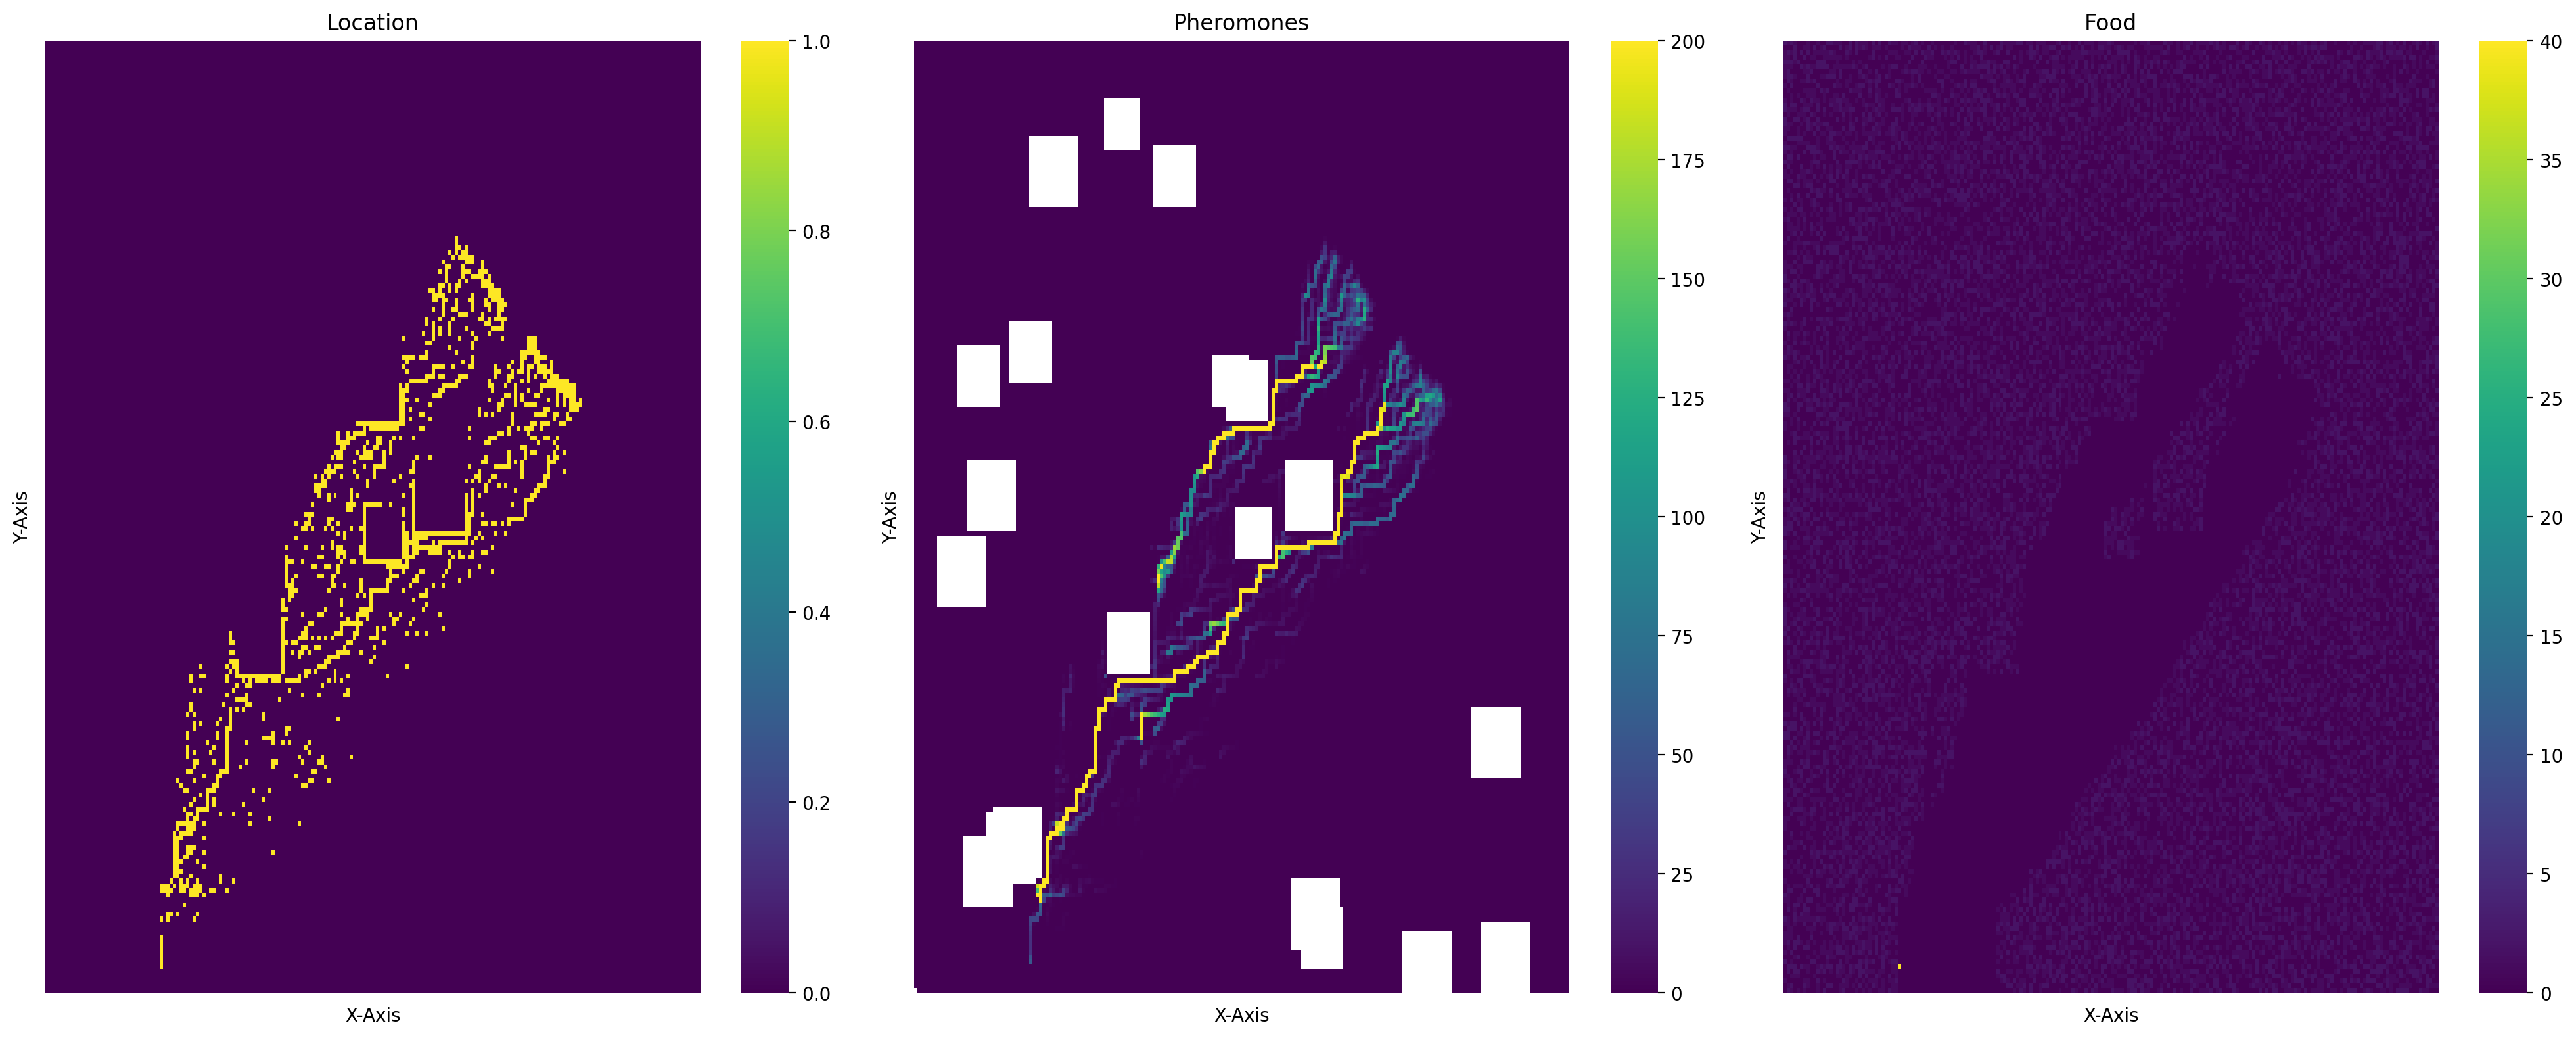

Currently 2758 ants are searching for food and 1242 ants transport food back to the nest. 2775 food items are in the nest.


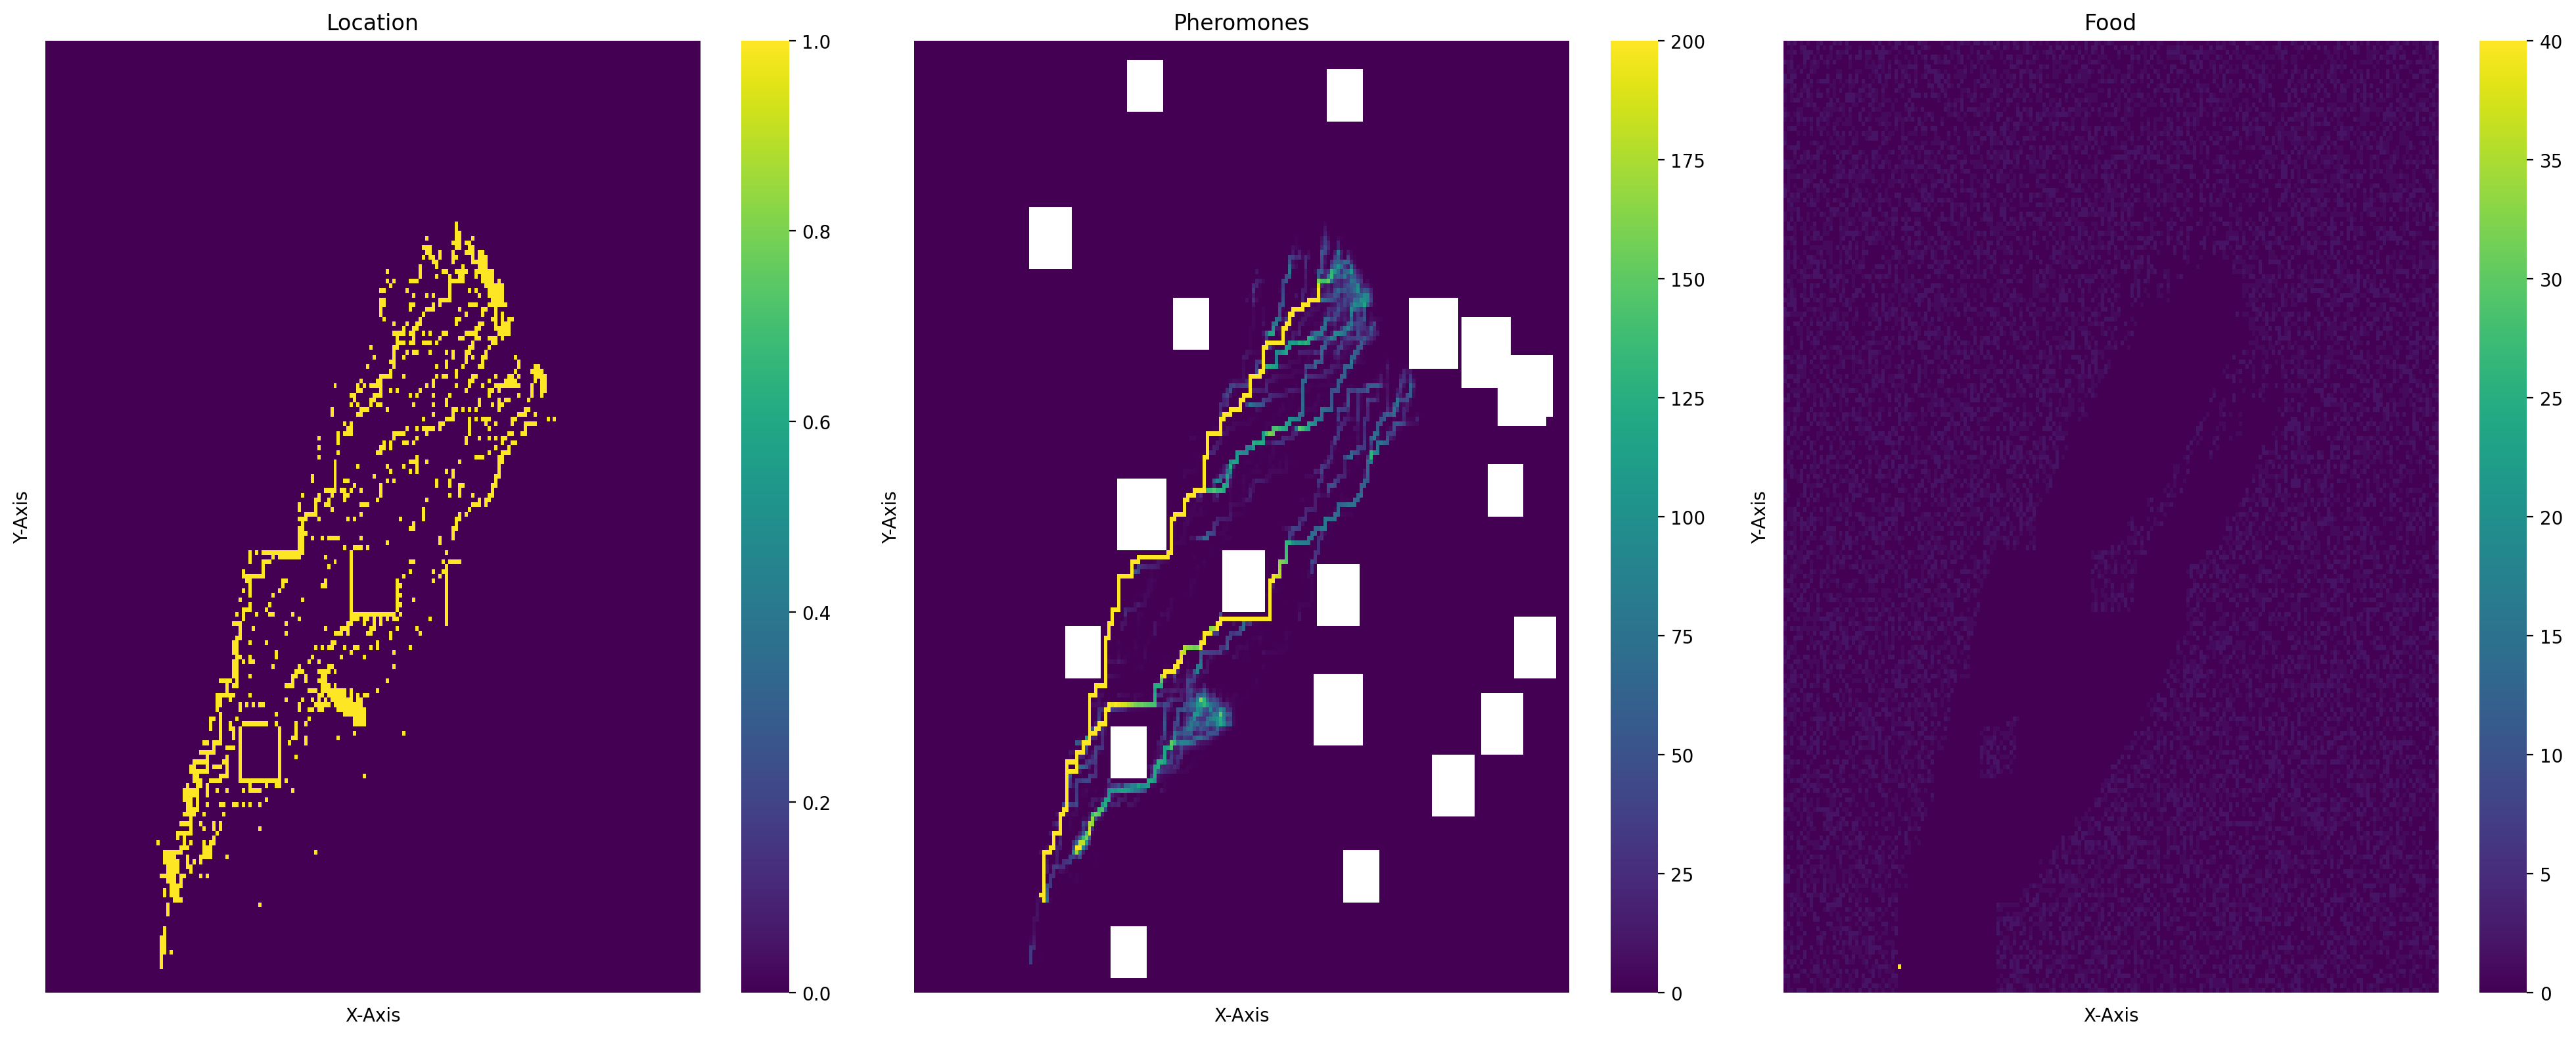

Currently 3065 ants are searching for food and 935 ants transport food back to the nest. 2827 food items are in the nest.


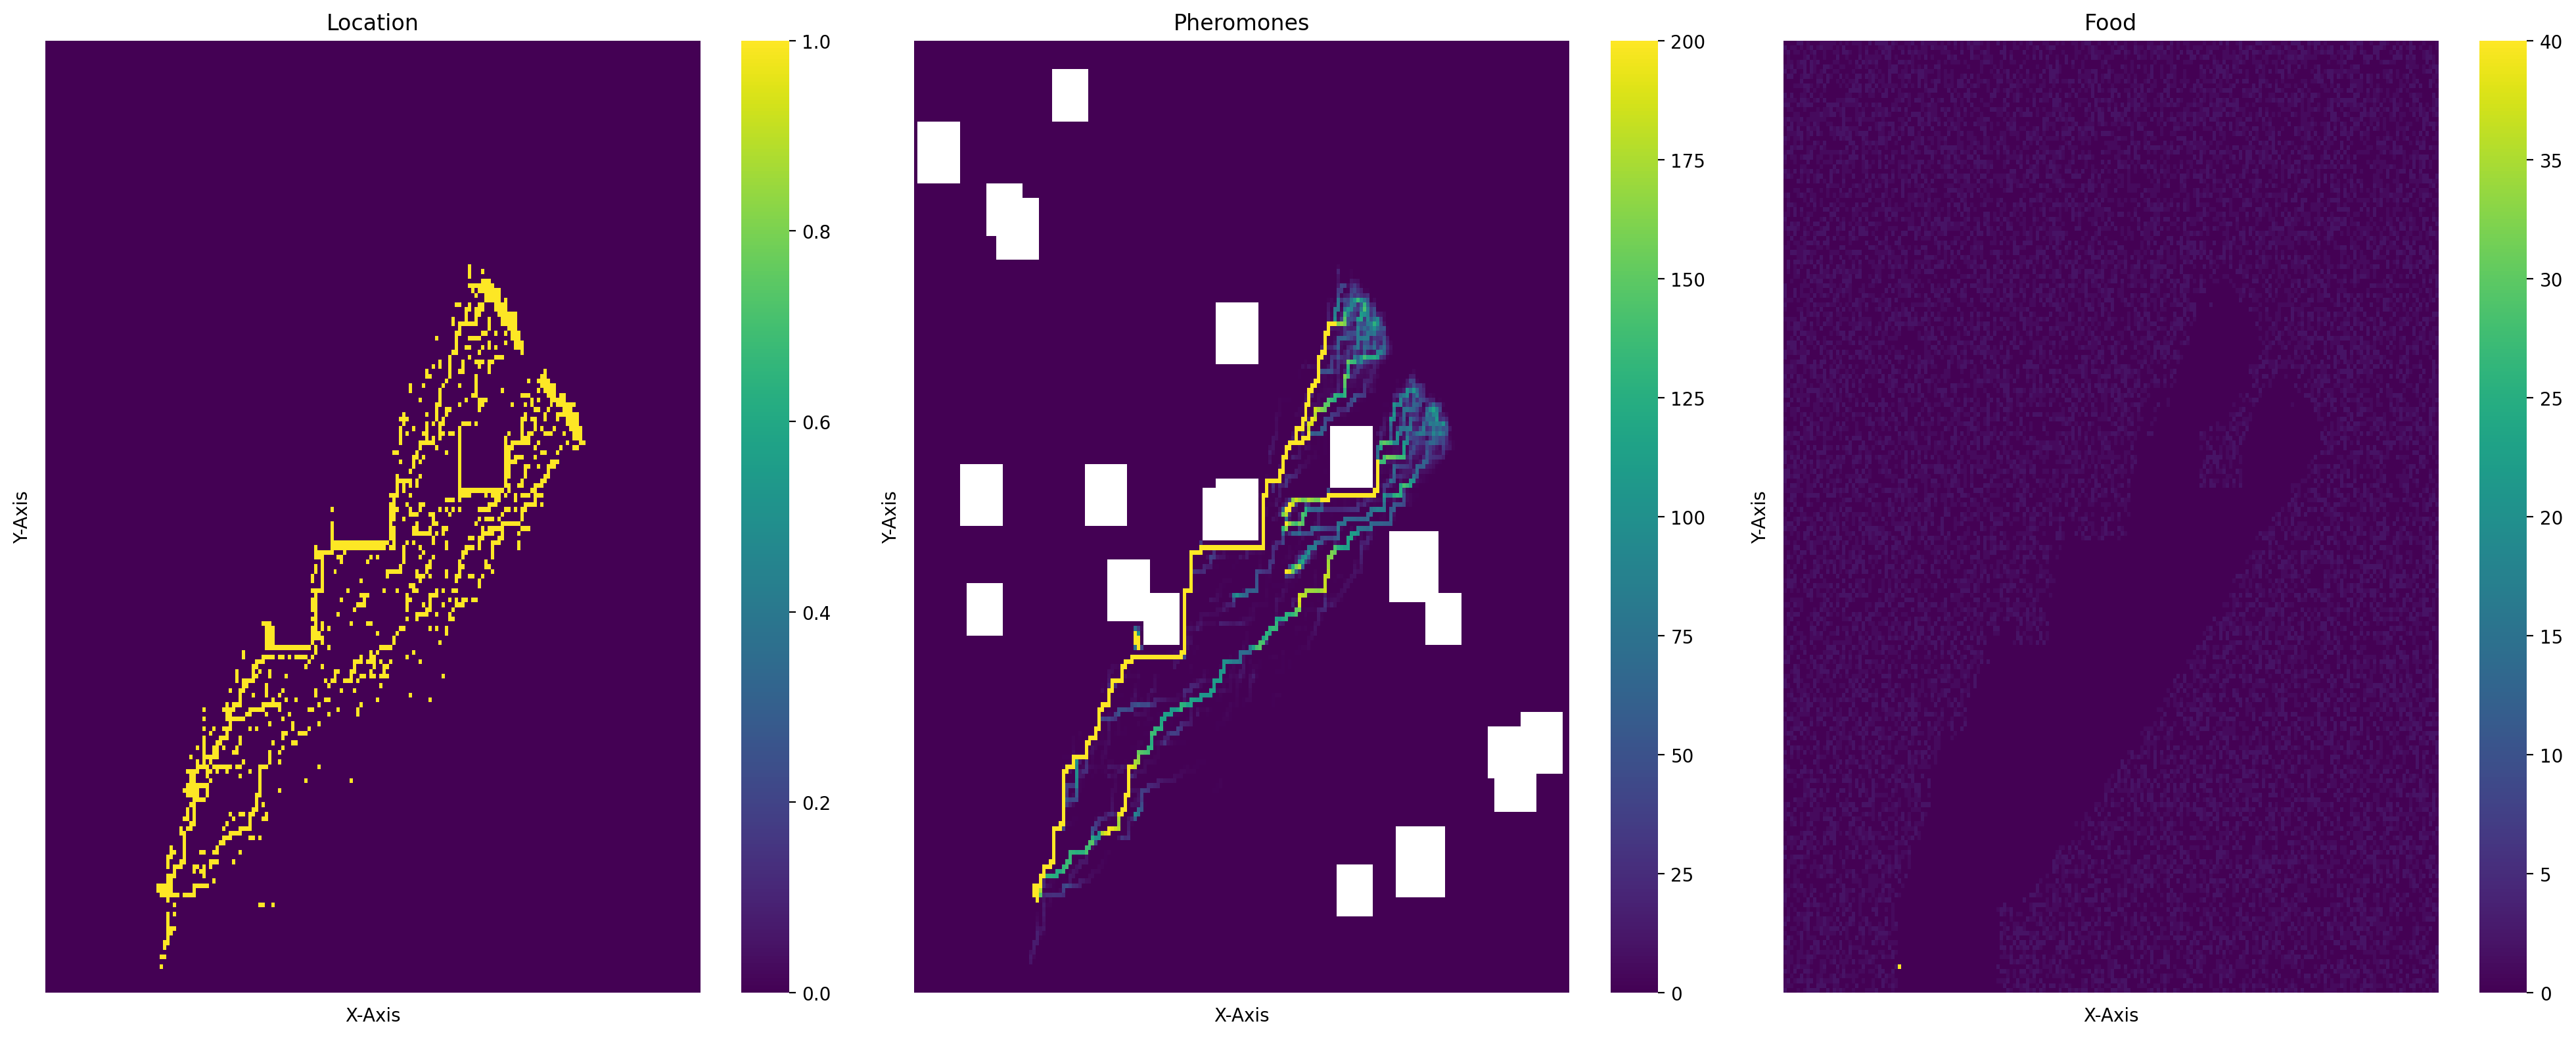

Currently 2888 ants are searching for food and 1112 ants transport food back to the nest. 3025 food items are in the nest.


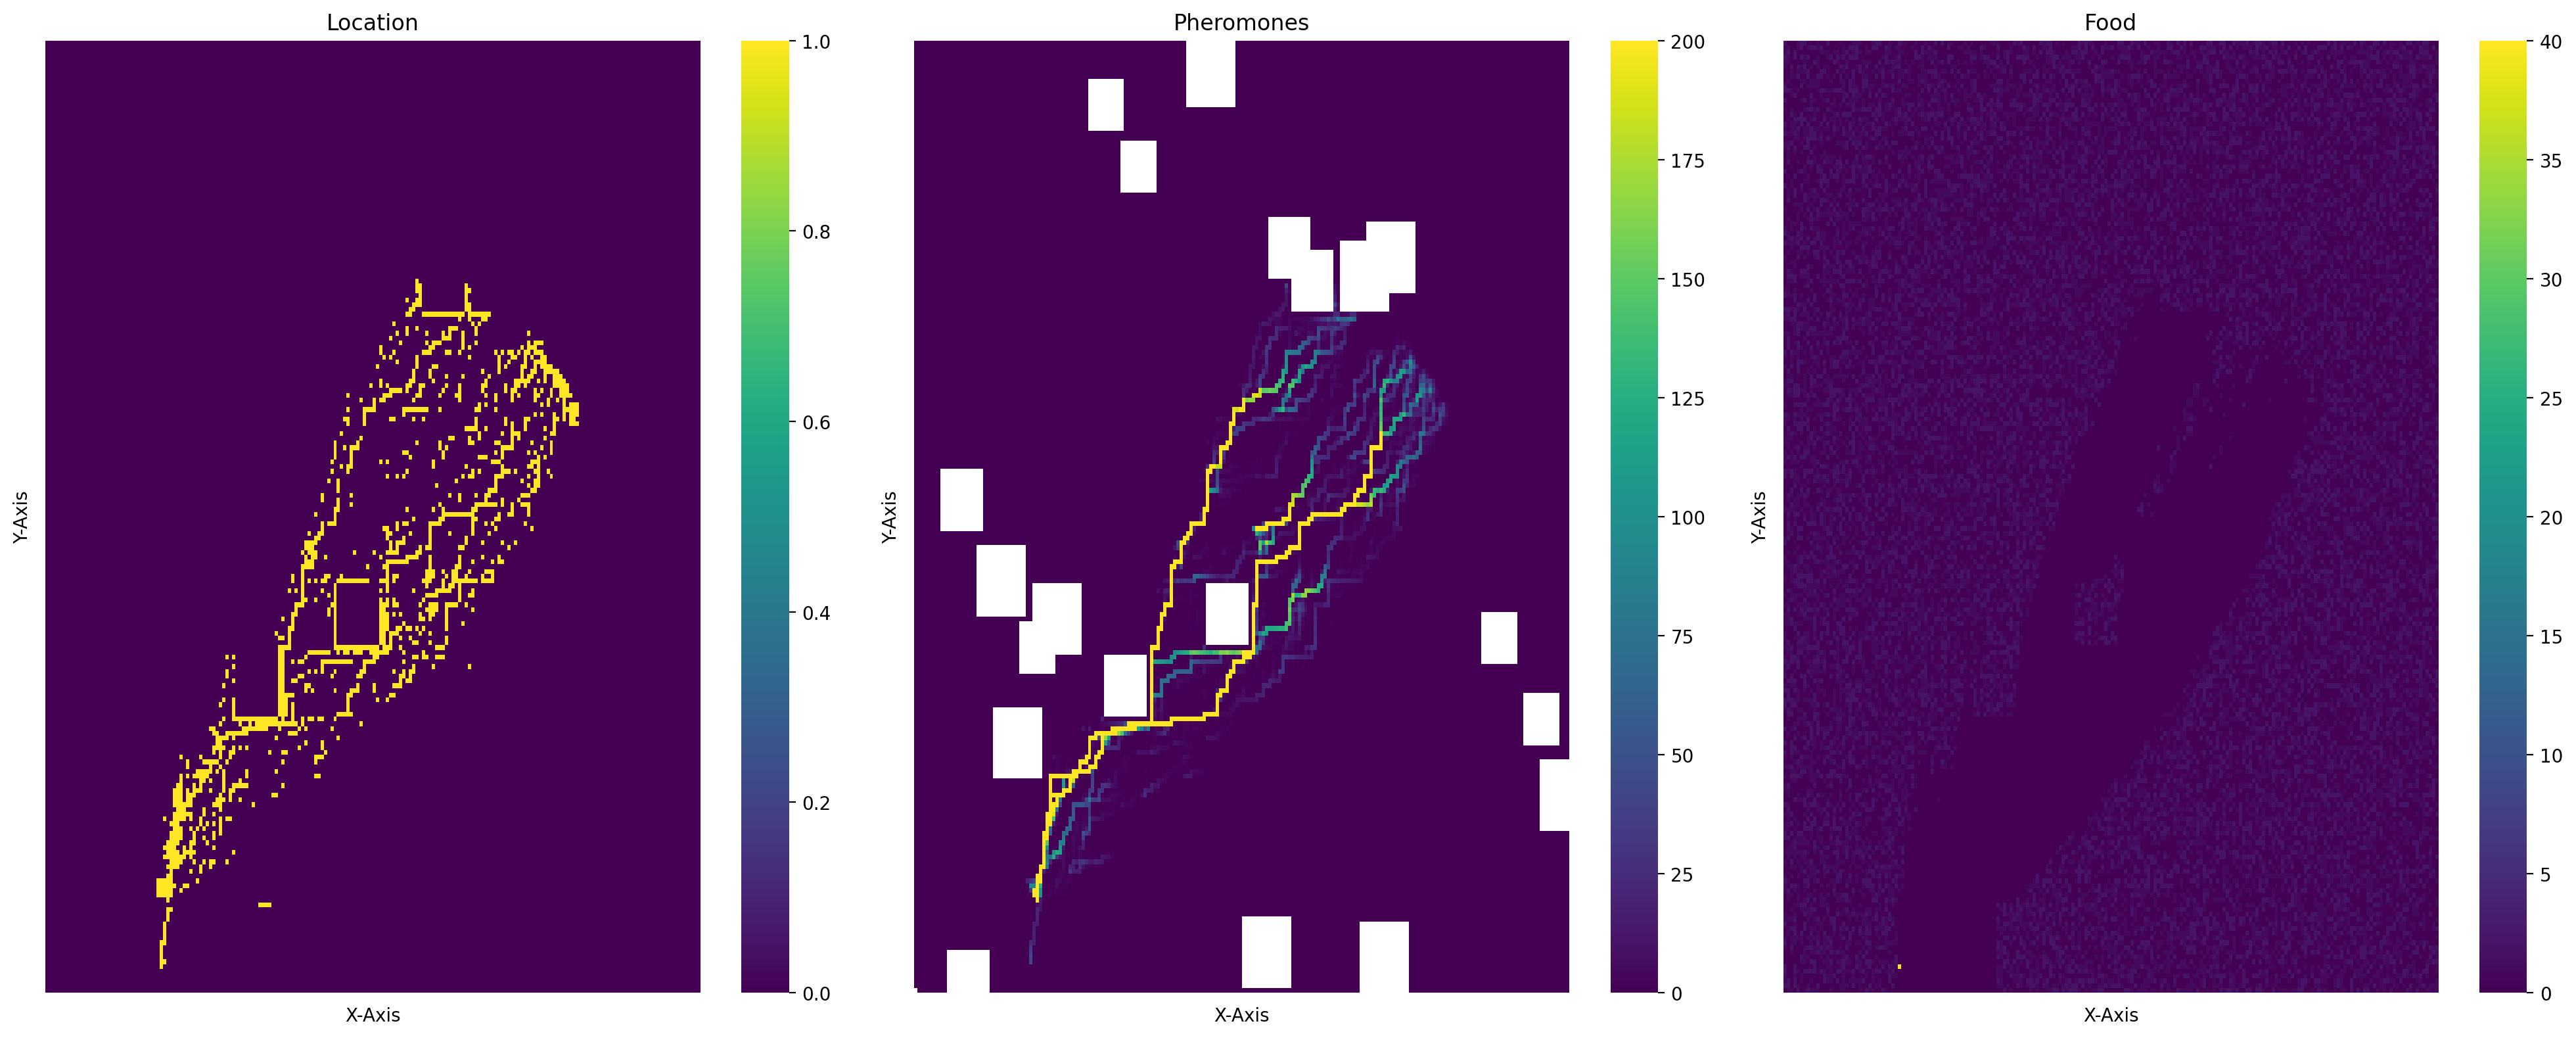

Currently 3278 ants are searching for food and 722 ants transport food back to the nest. 2213 food items are in the nest.


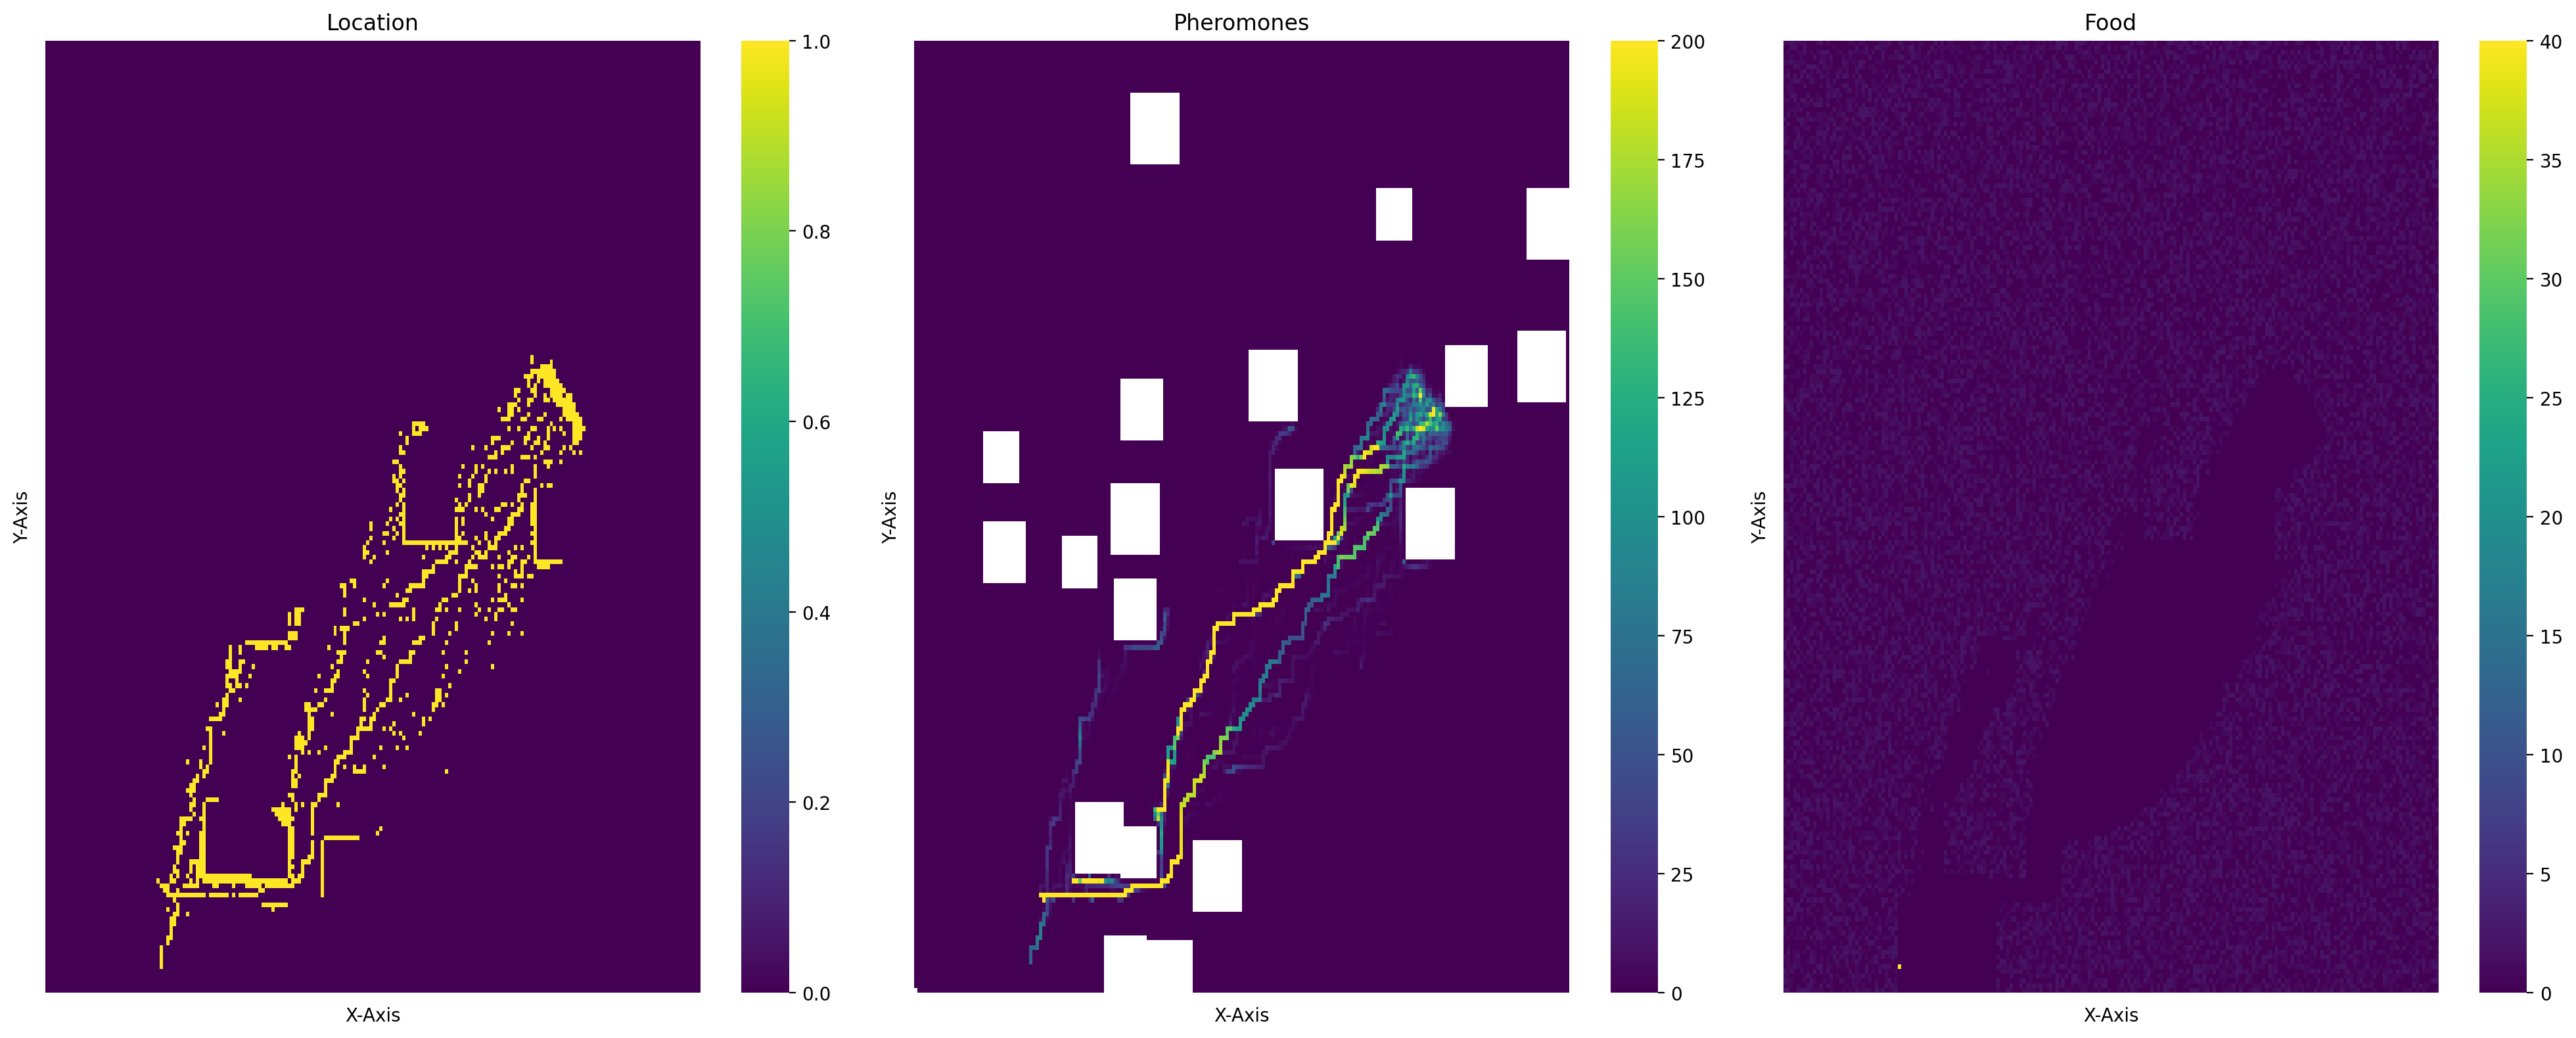

Currently 3080 ants are searching for food and 920 ants transport food back to the nest. 2966 food items are in the nest.


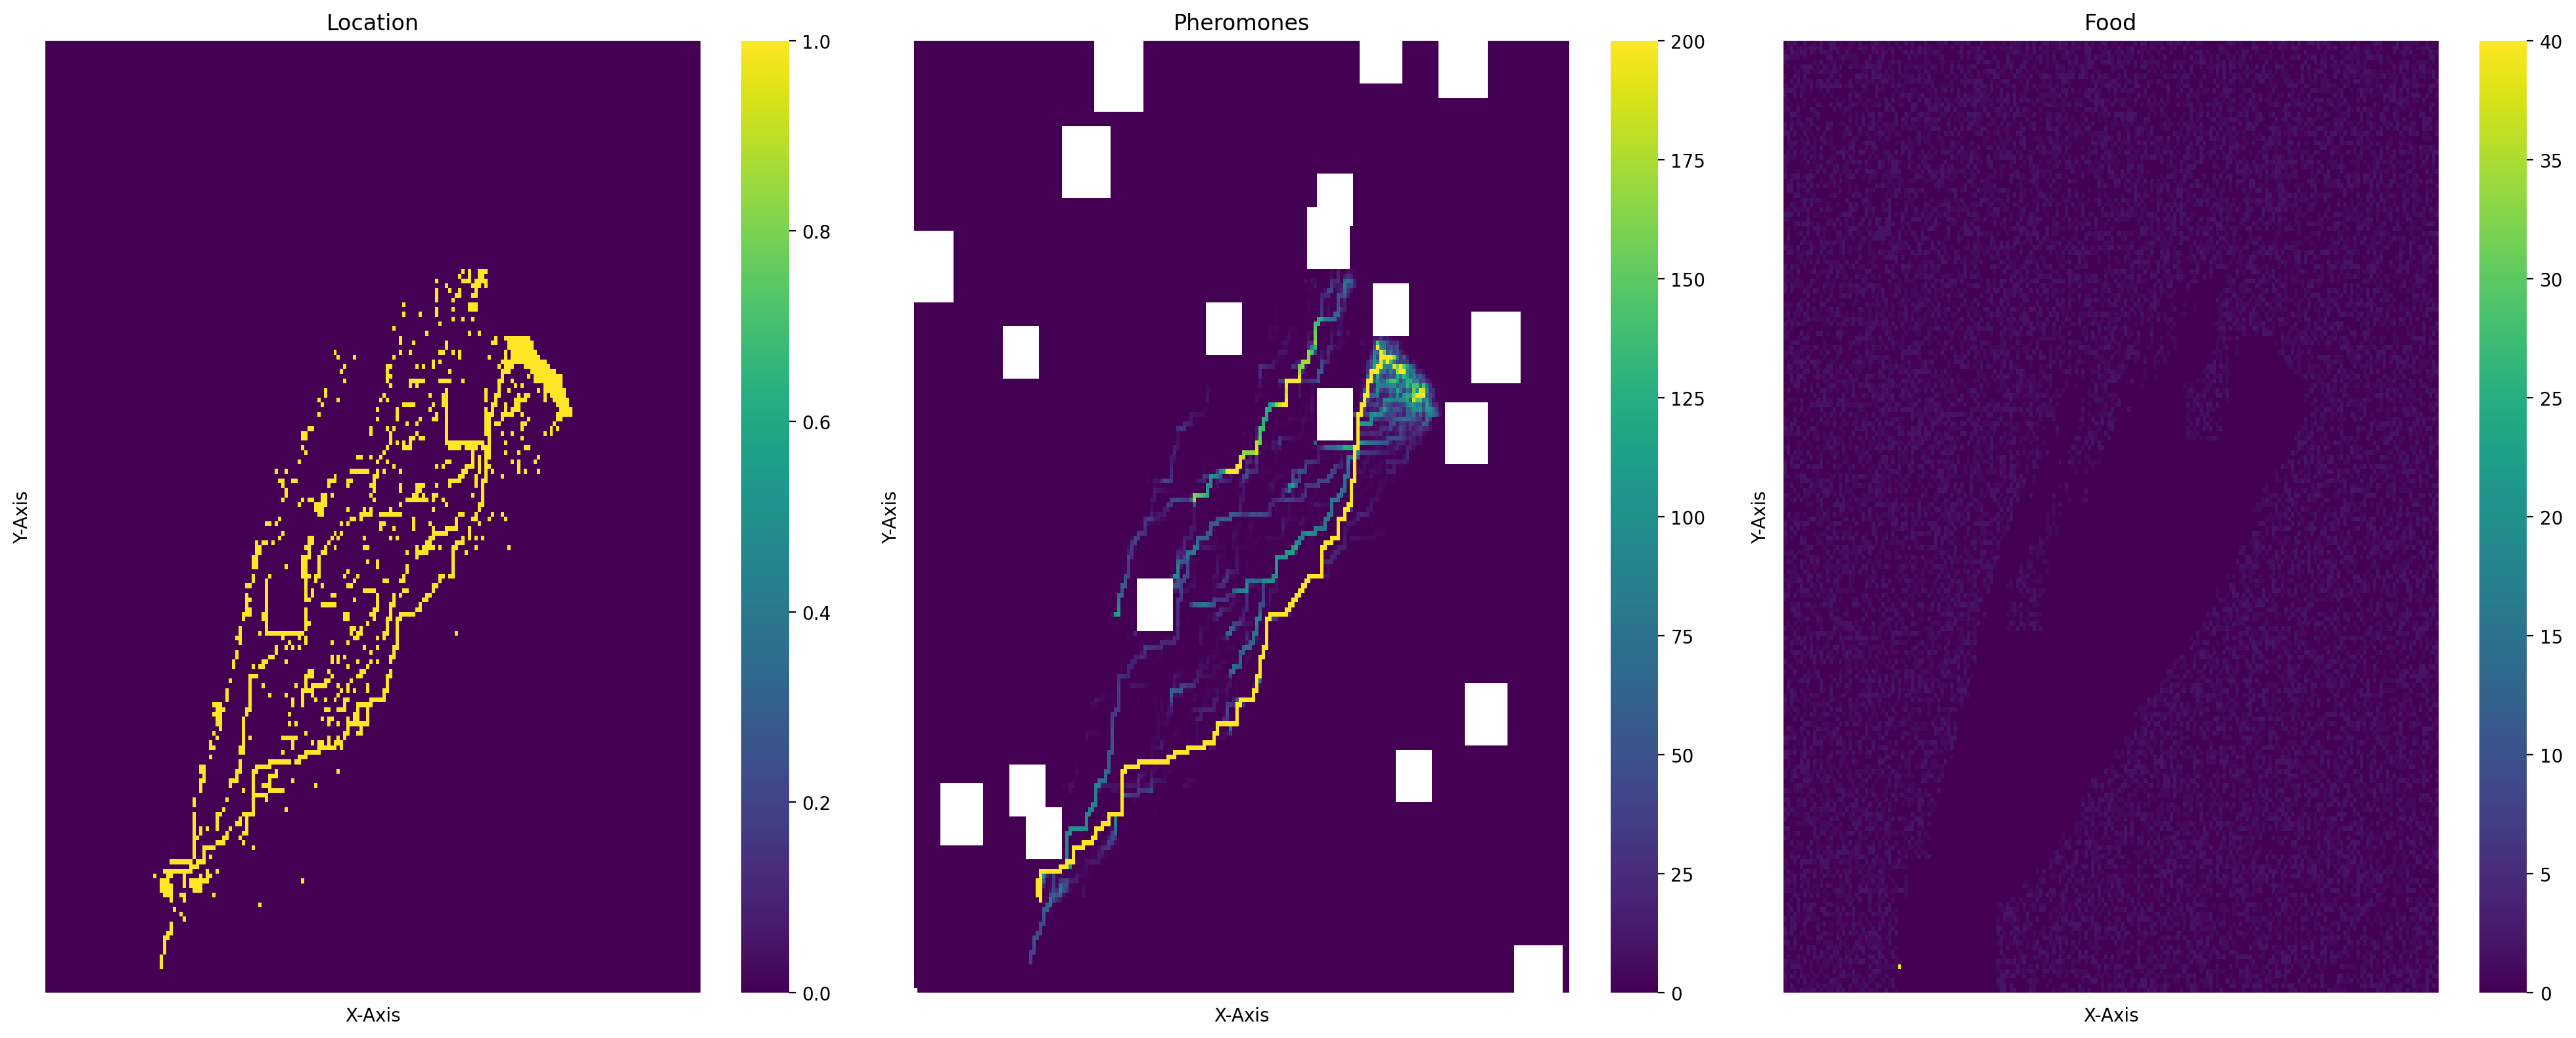

Currently 4000 ants are searching for food and 0 ants transport food back to the nest. 0 food items are in the nest.


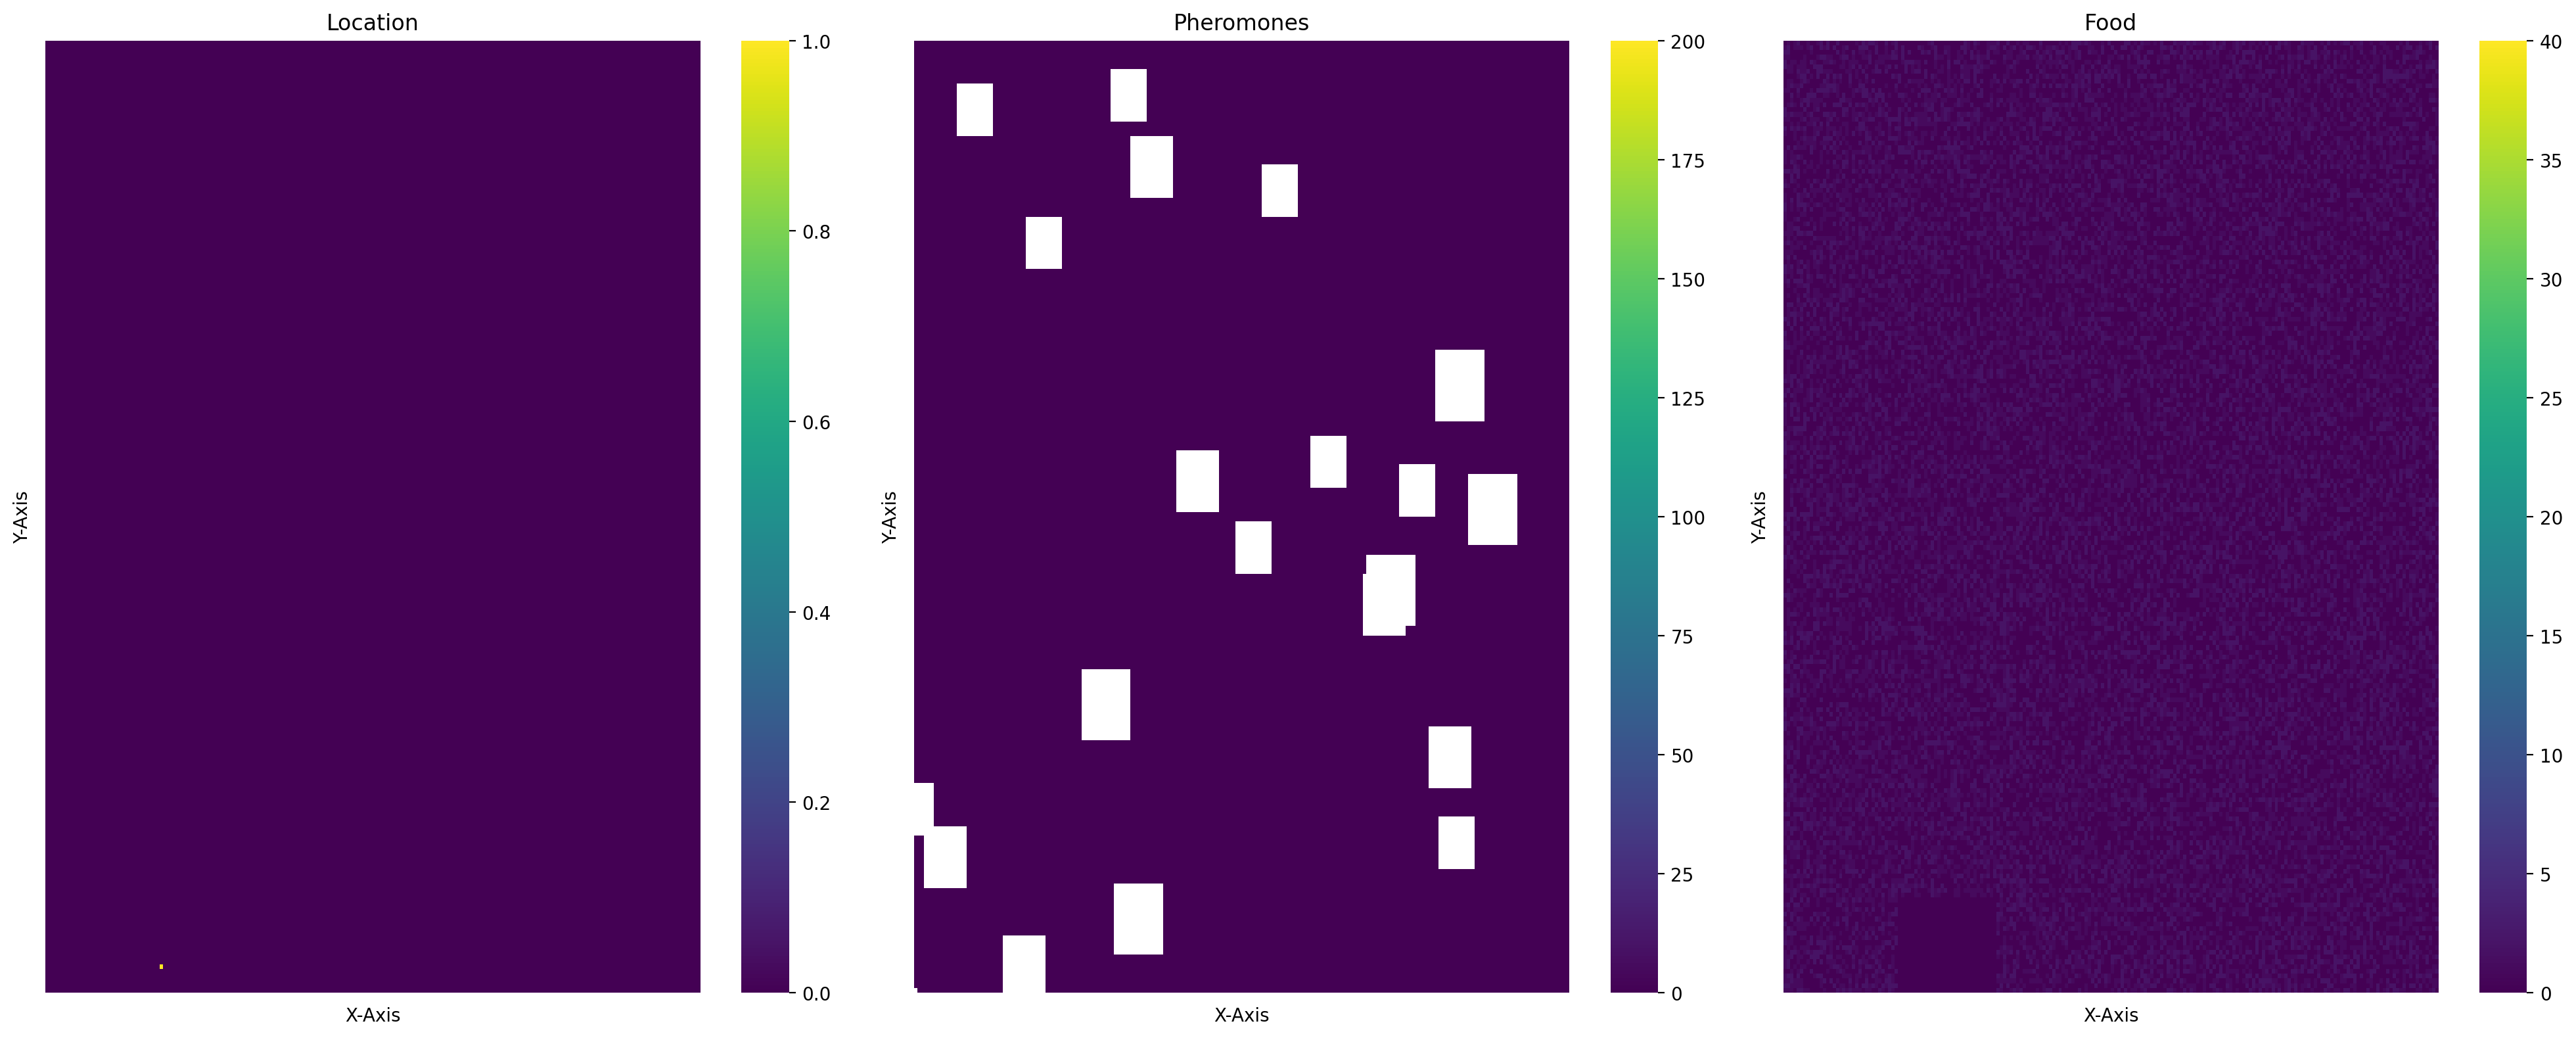

Currently 2709 ants are searching for food and 1291 ants transport food back to the nest. 2541 food items are in the nest.


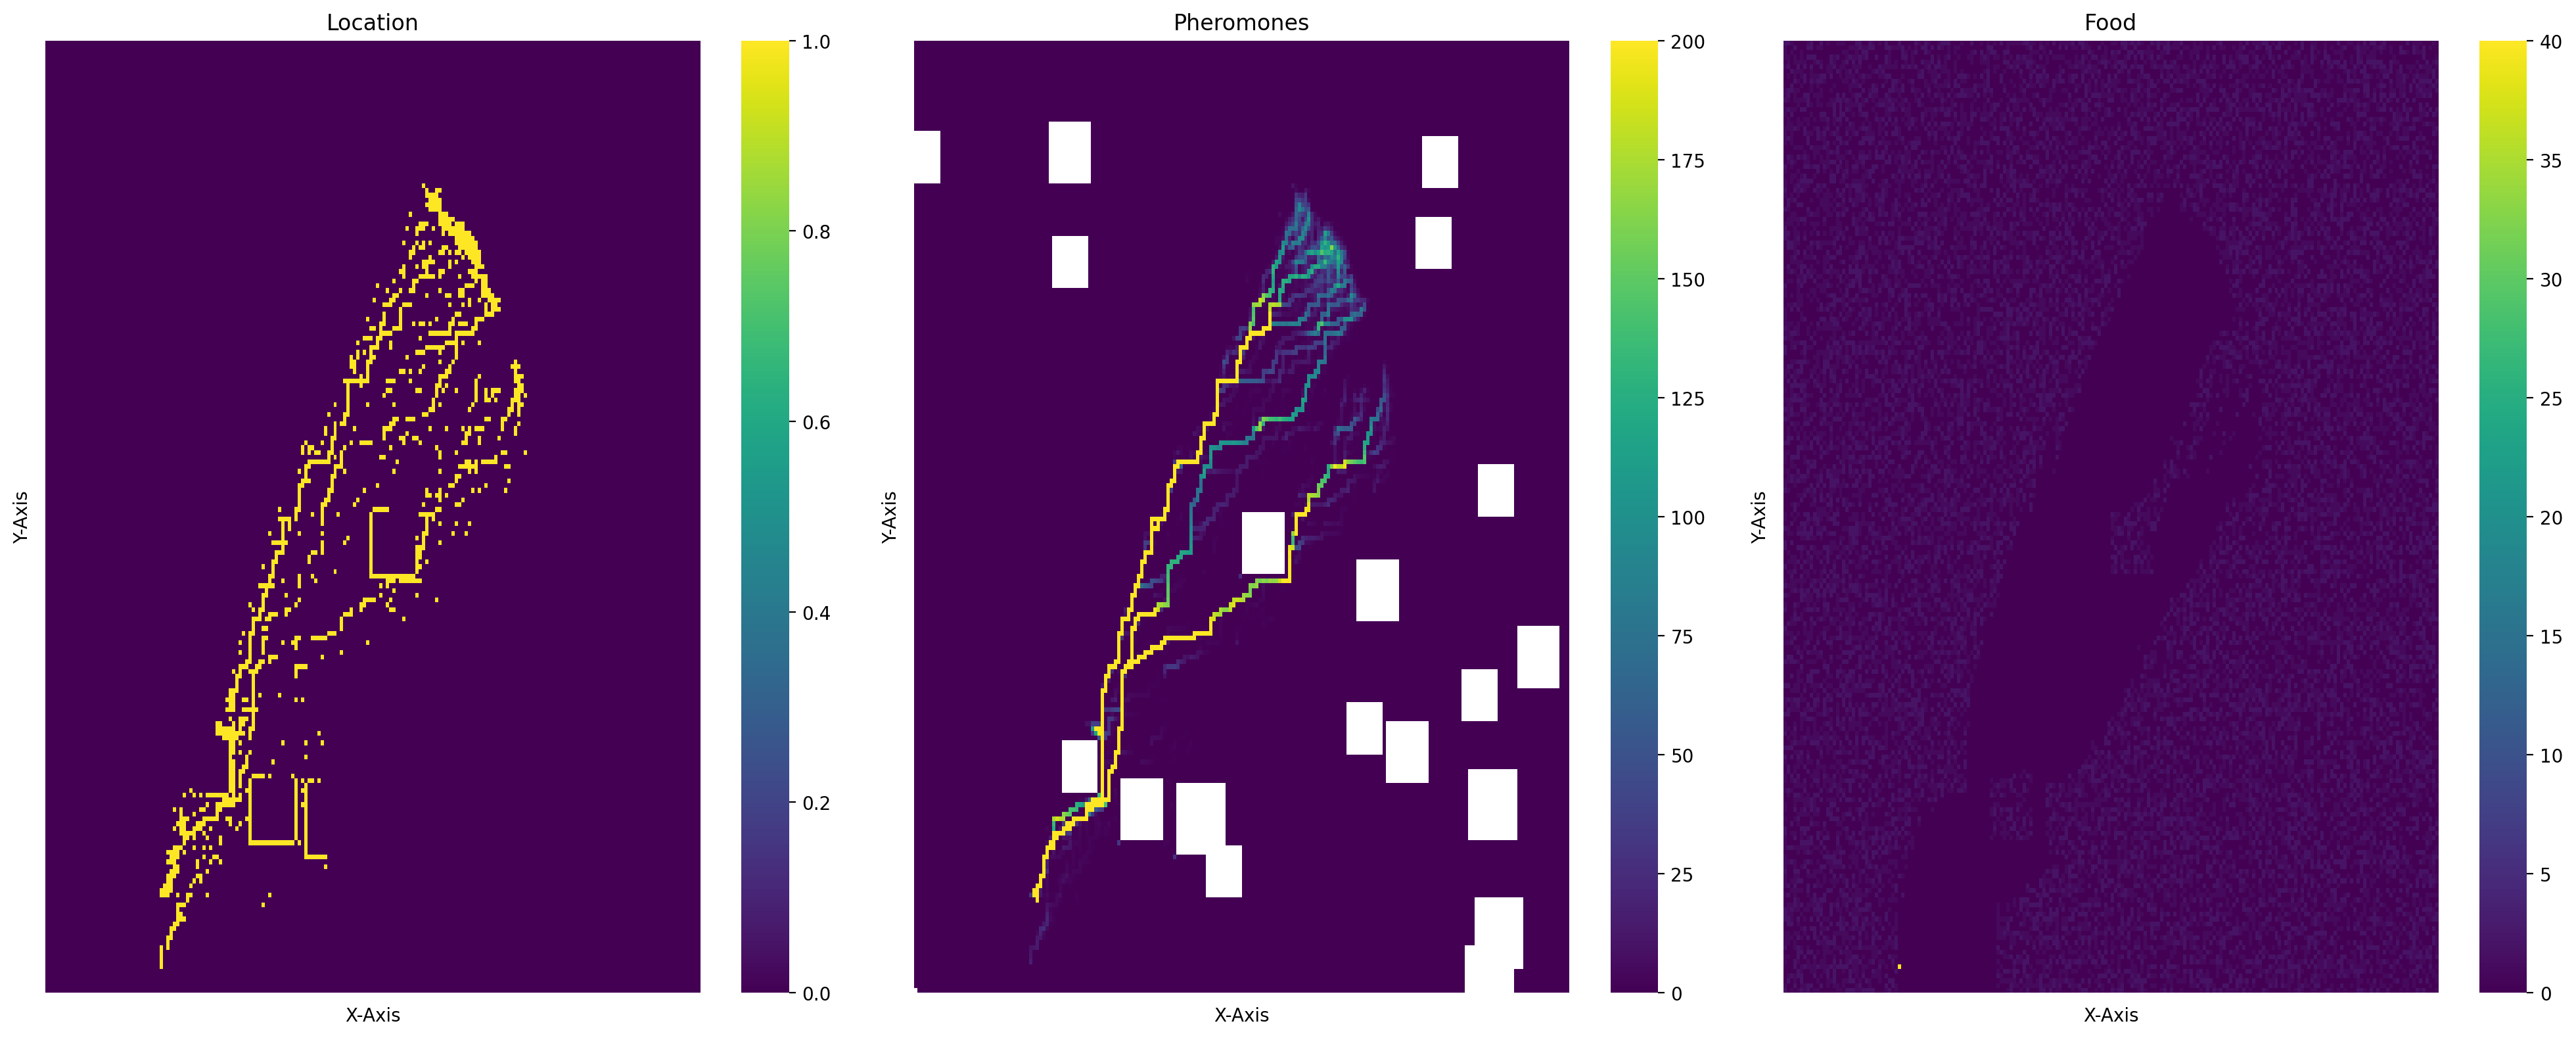

In [109]:
for i in range(20):
    nodes, node_array = create_nodes(n=40000,experiment=4,randomise_capacity = True,terrain=True, nests=False,realistic_world=False, evaporation_rate=1/30)
    new_nodes = model(nodes=nodes,steps=1300,ants_per_step=10,max_ants=4000)
    multiplot(new_nodes,one=False,two=False,total=True,exp='RxT')